# Introduction to Data Science and Machine Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

## Exercises

### Exercise 1

Compare (within a single plot) the monthly trends of

* electric energy consumption
* renewable energy production (solar, wind and the sum of the two).

Plot the yearly trend of the ratio between

* renewable energy production
* electric energy consumption.

### Exercise 2

Analyse the trend in solar energy production starting from $2012$.

Compare, starting from $2006$, the trends in

* solar energy production
* wind energy production
* total production of renewable energy.

### Exercise 3

Import and plot the time series [`alcohol_sales`](datasets/alcohol_sales.csv).

1. Find the series decomposition.
2. Plot the components and try to describe them
3. Analyse residual distribution and try to find out if they follow a normal, etc.

### Exercise 4

Import and plot the time series [`co2-ppm`]('https://pkgstore.datahub.io/core/co2-ppm-daily/co2-ppm-daily_csv/data/f2f91444294eec9f764430483fafc6be/co2-ppm-daily_csv.csv'). 

1. Try to plot the series and decompose it.
2. Find the distribution of the residual part. Does it follow a Gaussian curve?

### Exercise 5
Forecast and represent the solar energy production of $2017$, by using years from $2012$ to $2016$ as training data. 

You should use at least 2 different models and compare results.

### Exercise 6

Import, plot and analyse the time series of [Italian covid cases](https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv).

1. Try to plot at normal and log scales the new cases, hospitalised and deaths. What can you say?
2. Find the _lag of maximum correlation_ between the series of new cases and deaths to determine how delayed is one curve with respect to the other.
3. Taking a forecast window of 3 weeks, try to forecast the new cases tomorrow. Think of what metric is the most suitable to use.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from IPython.display import display, Latex
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.grid'] = True

Importing plotly failed. Interactive plots will not work.


<h1> Exercise 1 </h1>

In [2]:
url_data = "https://raw.githubusercontent.com/fbagattini/Lezioni/master/data/OPSD_Germany_all.csv"

df = pd.read_csv(url_data,
                 parse_dates=True,
                 index_col='Date')
df

Consumption     Wind   Solar
Date                                    
2006-01-01   1069.18400      NaN     NaN
2006-01-02   1380.52100      NaN     NaN
2006-01-03   1442.53300      NaN     NaN
2006-01-04   1457.21700      NaN     NaN
2006-01-05   1477.13100      NaN     NaN
...                 ...      ...     ...
2017-12-27   1263.94091  394.507  16.530
2017-12-28   1299.86398  506.424  14.162
2017-12-29   1295.08753  584.277  29.854
2017-12-30   1215.44897  721.247   7.467
2017-12-31   1107.11488  721.176  19.980

[4383 rows x 3 columns]

<AxesSubplot: xlabel='Date'>

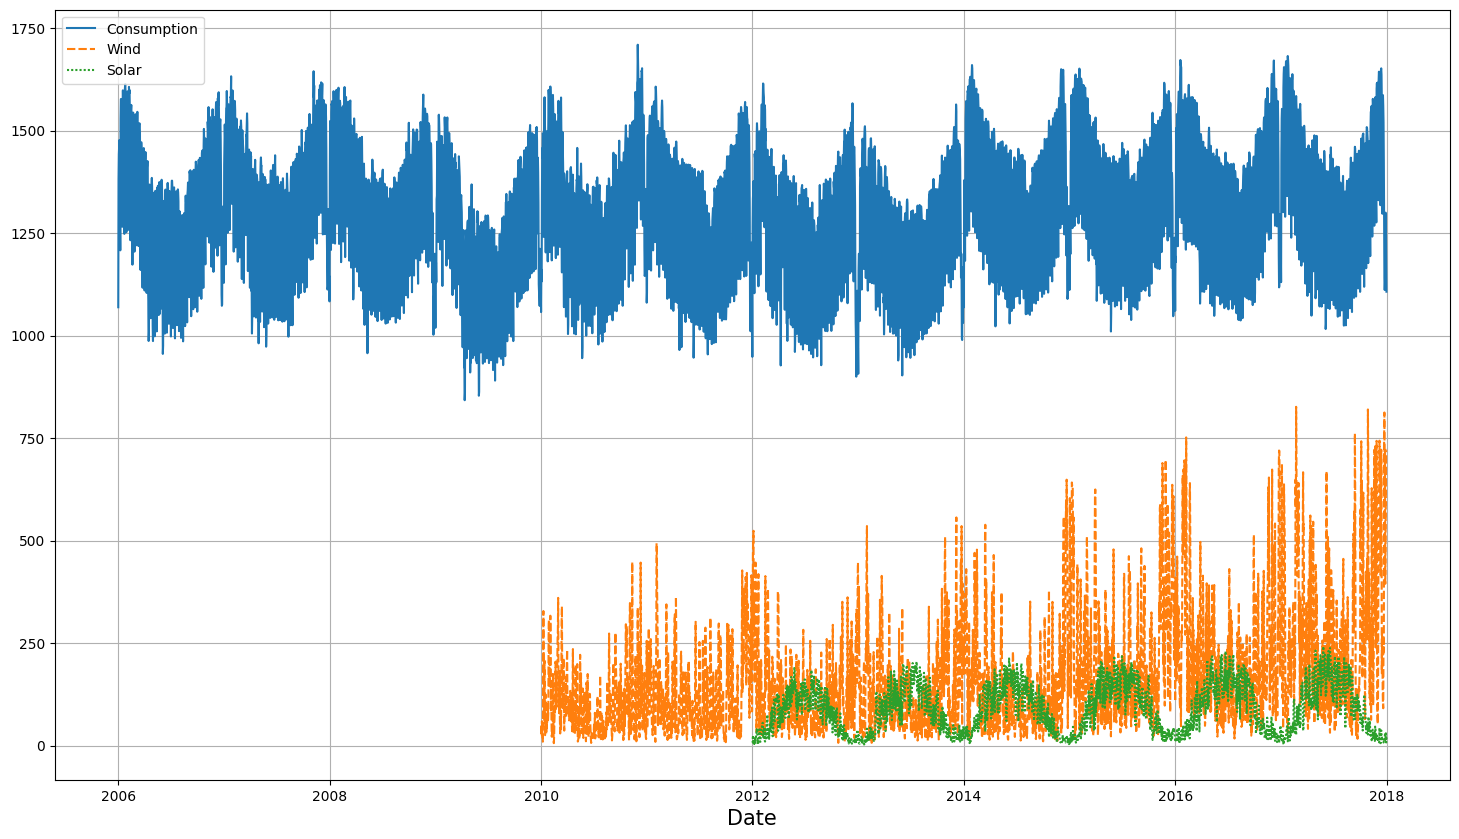

In [3]:
sns.lineplot(data = df)

Set to 0 data of Solar and Wind columns before the start of relevation

<AxesSubplot: xlabel='Date'>

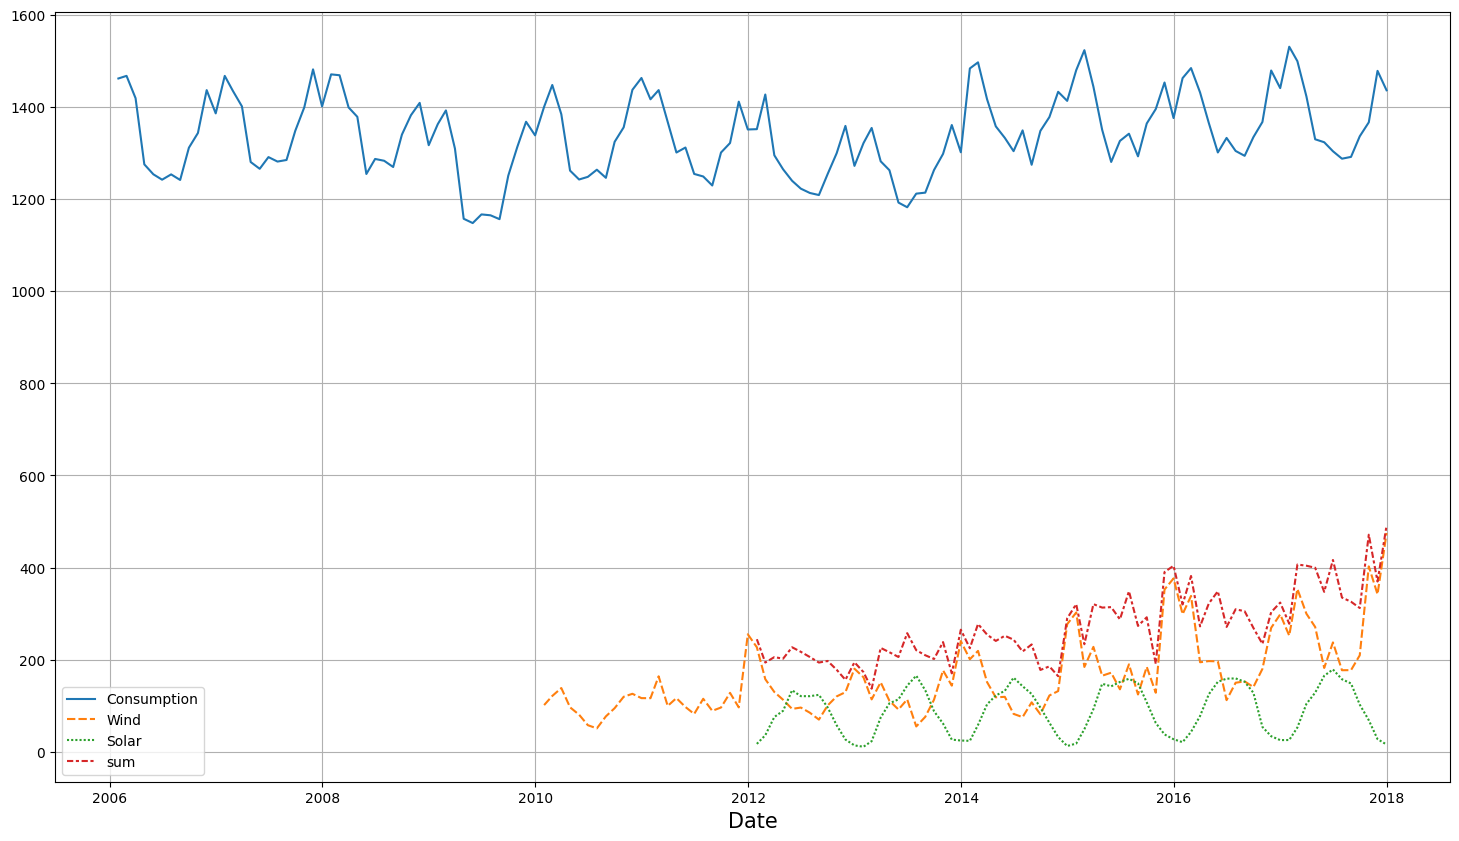

In [4]:
df1 = df.resample('M').mean()
df1['sum'] = df1['Wind'] + df1['Solar']
sns.lineplot(data = df1)

<AxesSubplot: xlabel='Date'>

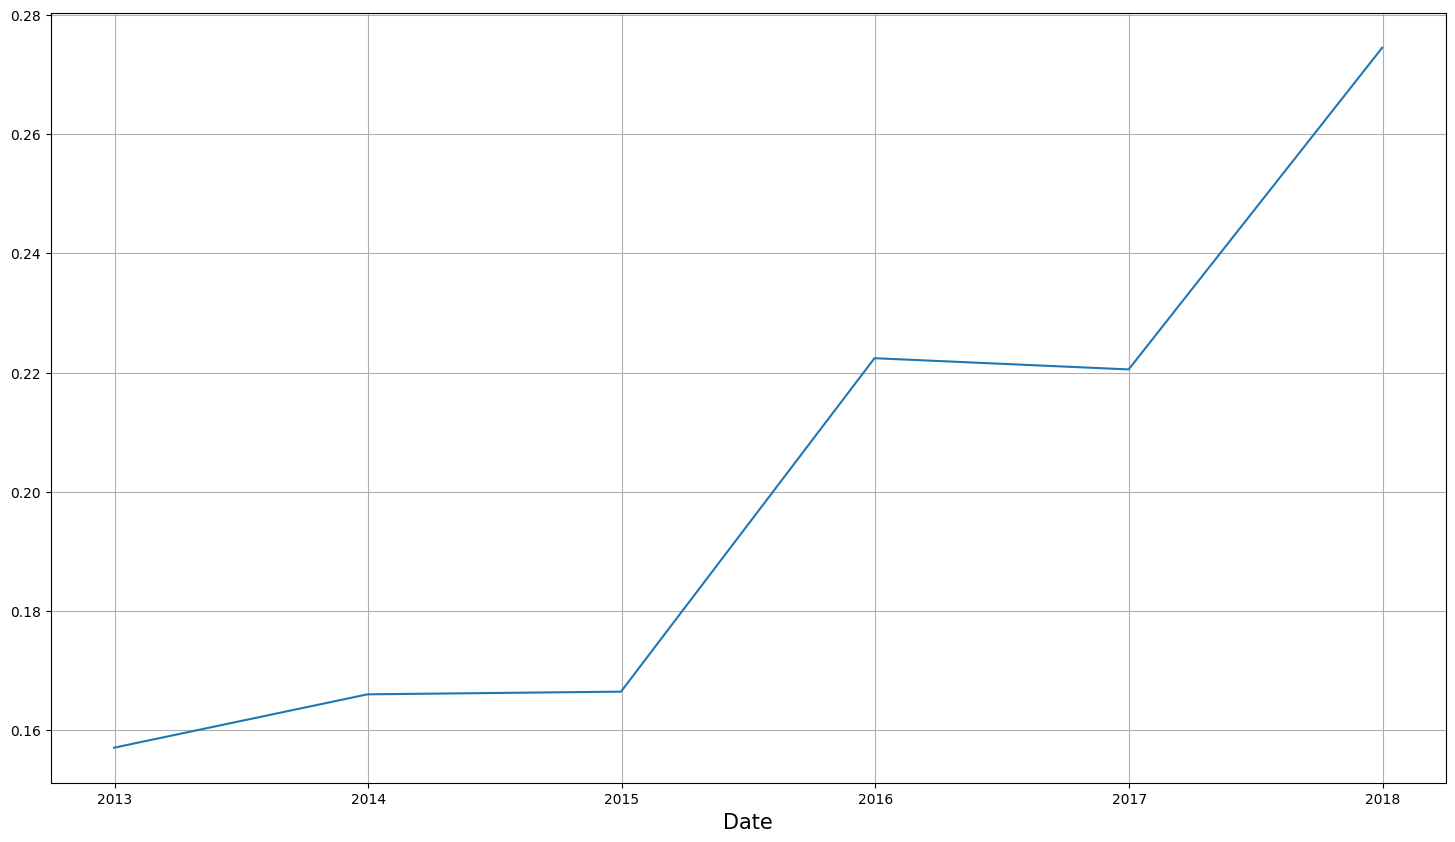

In [5]:
df2 = df.resample('Y').mean()
dfratio = (df2['Wind'] + df2['Solar'])/df2['Consumption']
sns.lineplot(data = dfratio)

<h1> Exercise 2 </h1>

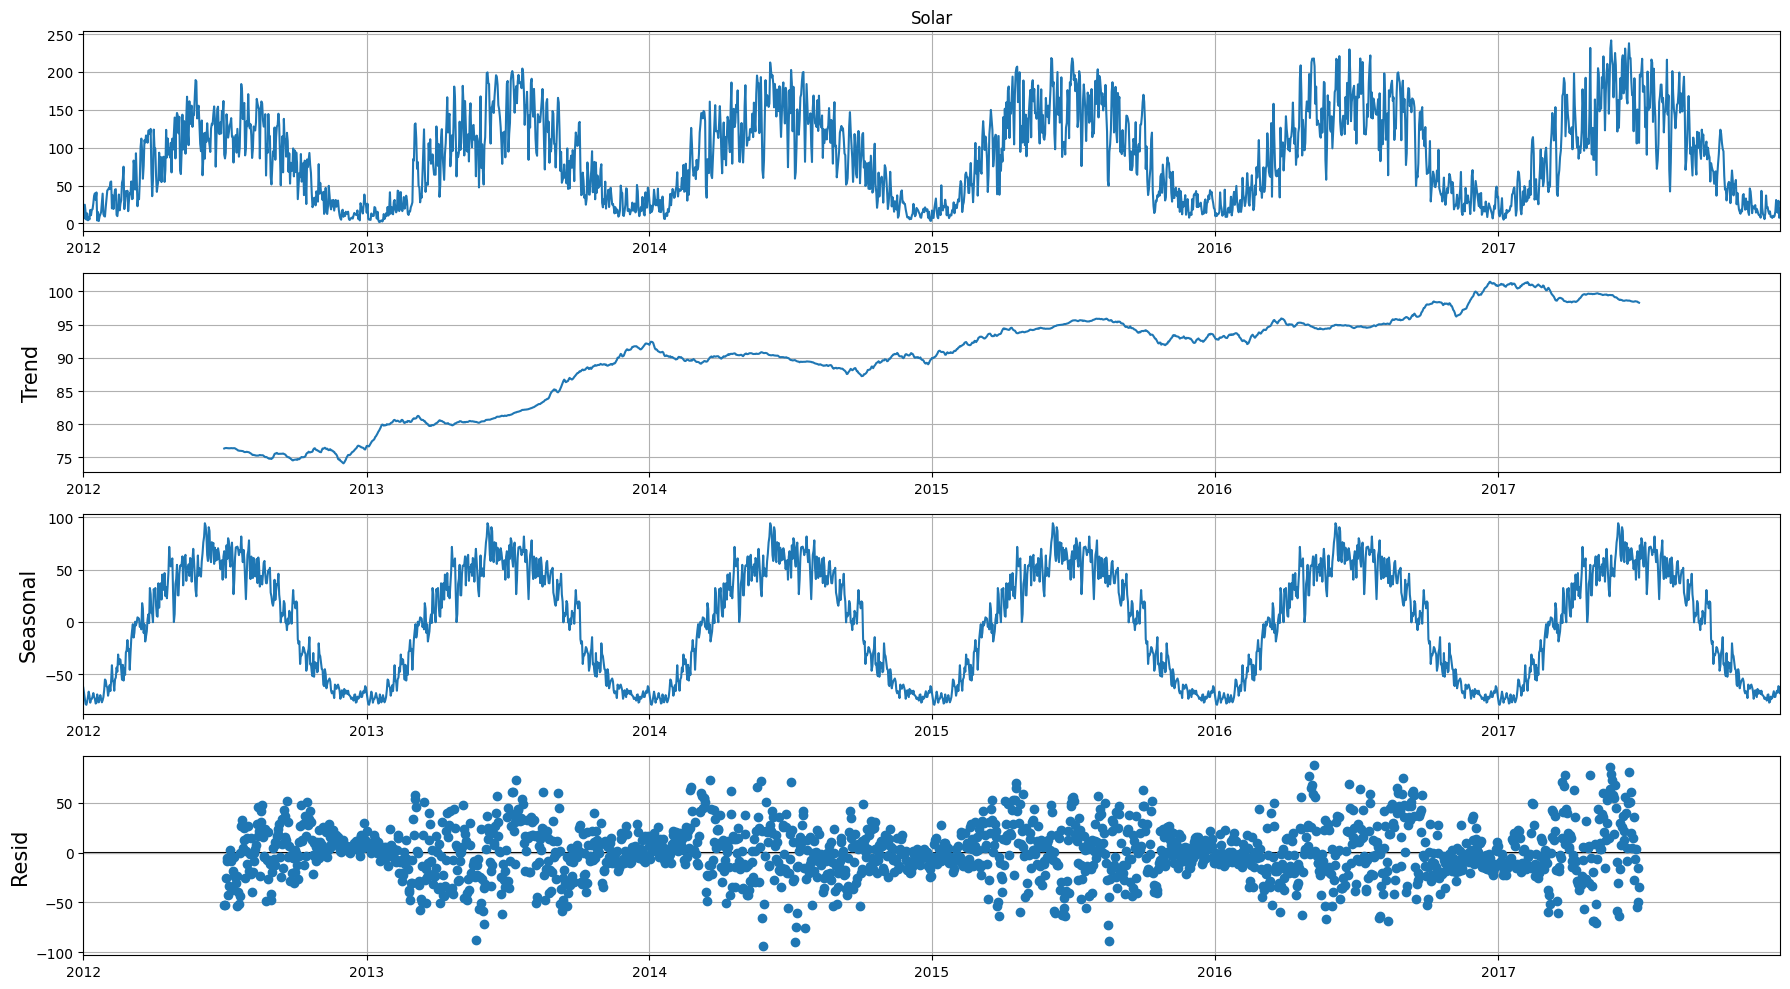

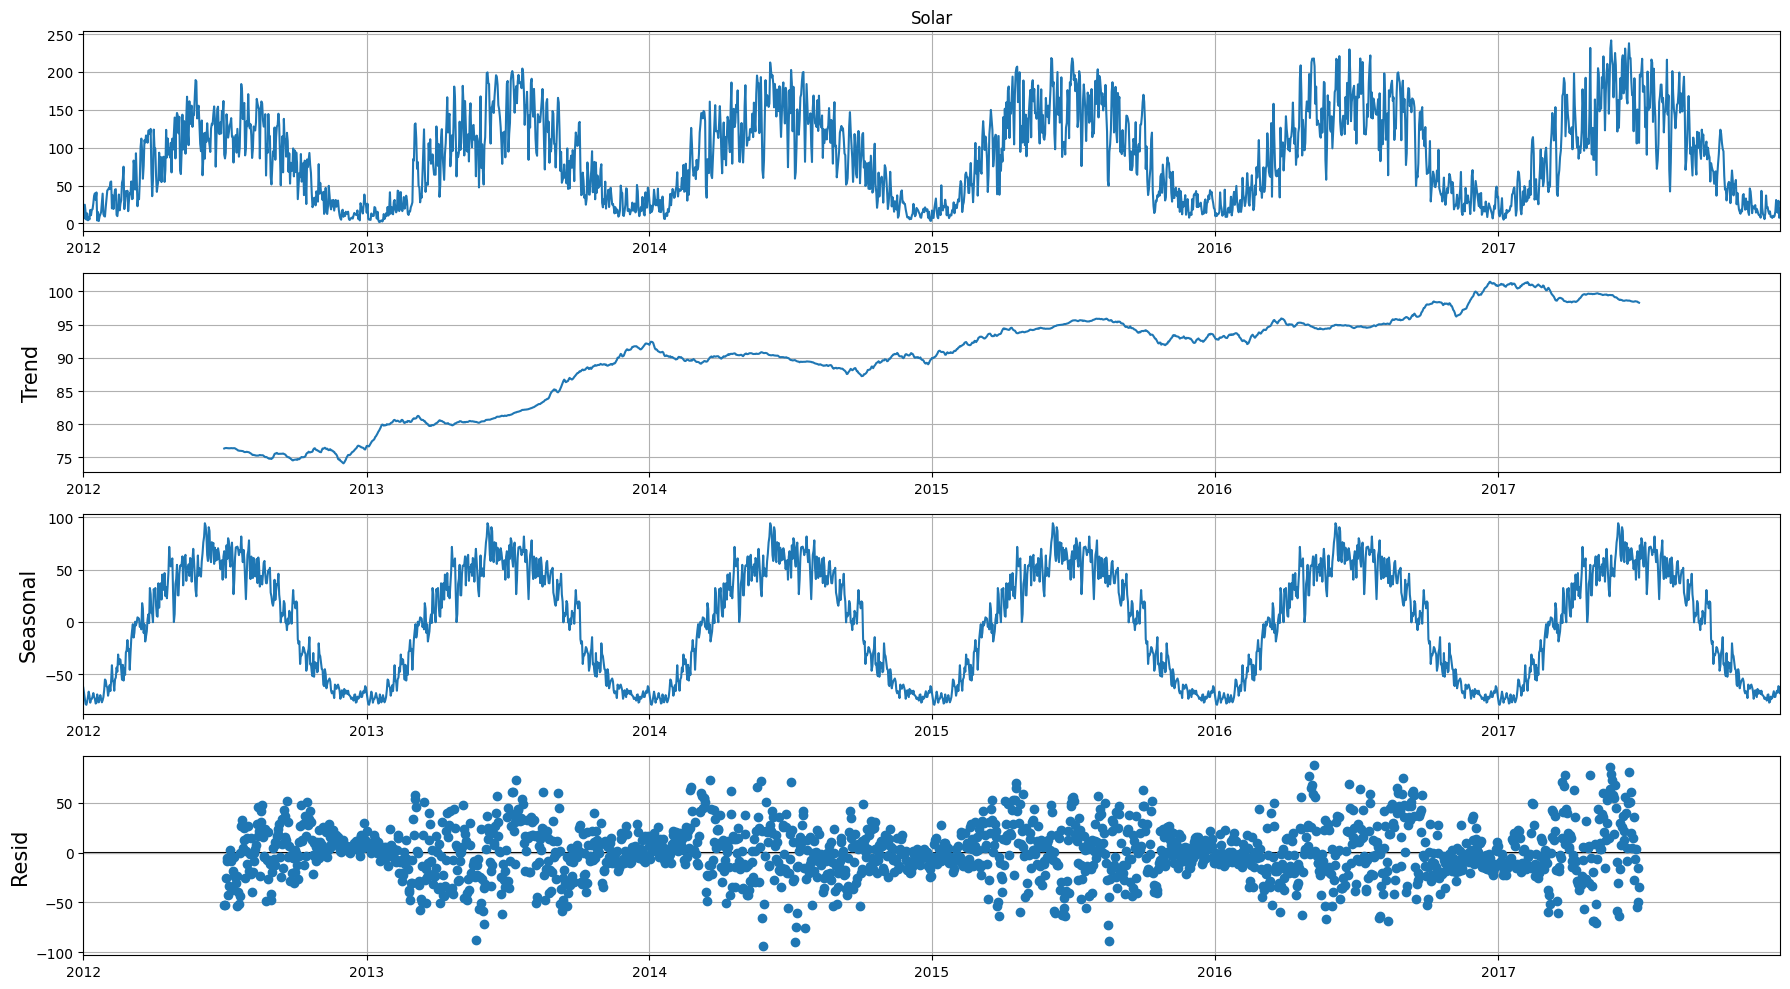

In [6]:
solar = df['2012':]['Solar']
decomposition = seasonal_decompose(solar.fillna(method= 'ffill'), period = 365)
decomposition.plot()

0.3788778324889008 26.631598960584487


<IPython.core.display.Latex object>

Test = 3.290217480857622


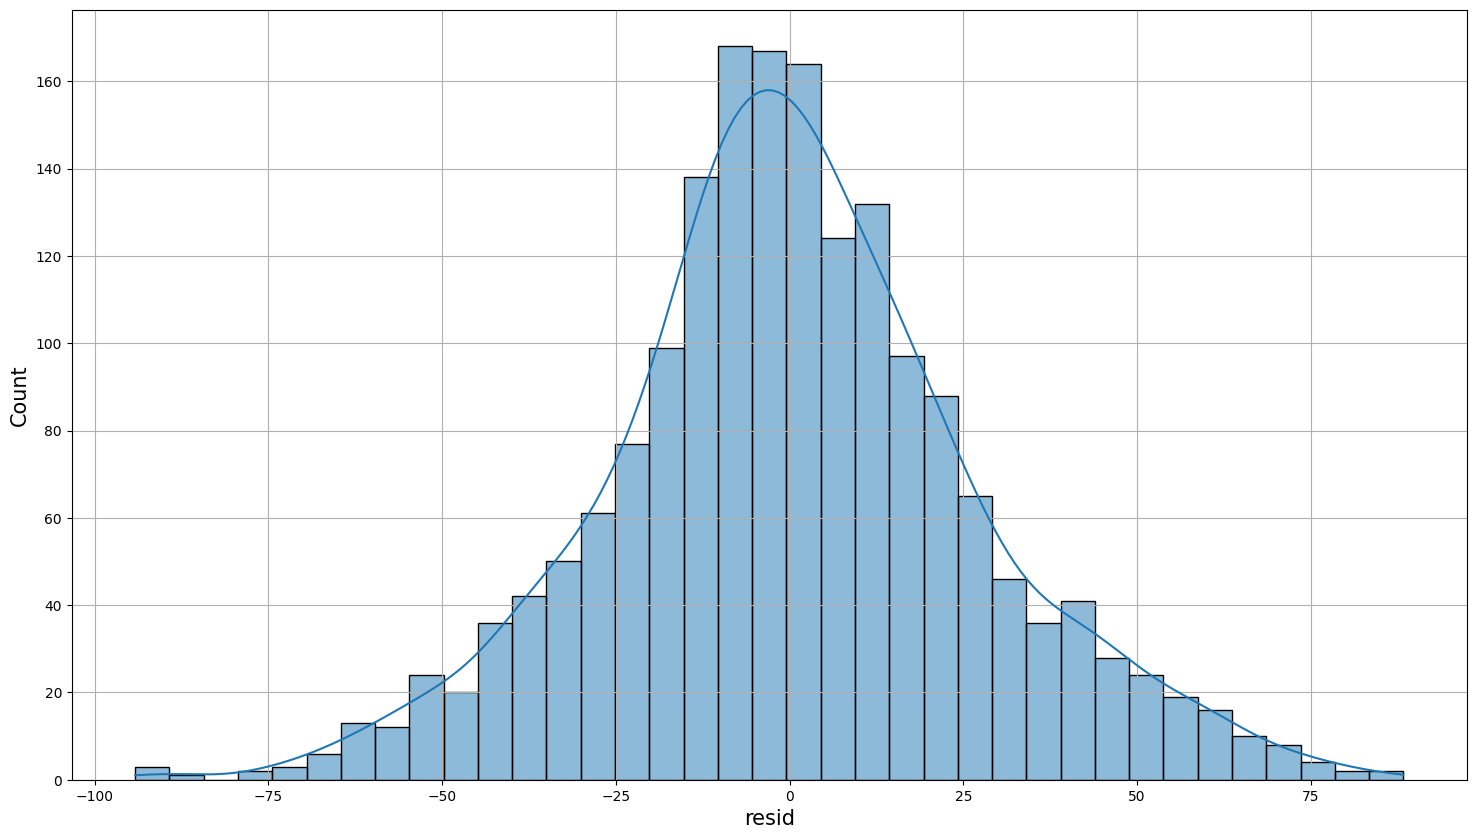

In [7]:
res = decomposition.resid
sns.histplot(res, kde = True)
print(np.mean(res), np.std(res))

counts, bins = np.histogram(res.dropna(), bins=int(np.sqrt(res.dropna().shape[0])))
chi = scipy.stats.chisquare(counts)
expected = res.dropna().shape[0] -2
test = np.abs(expected - chi[0])/np.sqrt(2*expected)

display(Latex(f'expected $\chi^2$ value = {expected}, obtained $\chi^2$ value = {chi[0]}, p-value = {chi[1]}')) 
print(f'Test = {test}')

Looking at the graph and the chisqaure test we can't consider the series stationary, because residual's distribution is not gaussian
<br>
Just for comparison let's see a multiplicative model

In [8]:
decomposition = seasonal_decompose(solar.fillna(method= 'ffill'), period = 365,  model='multiplicative')

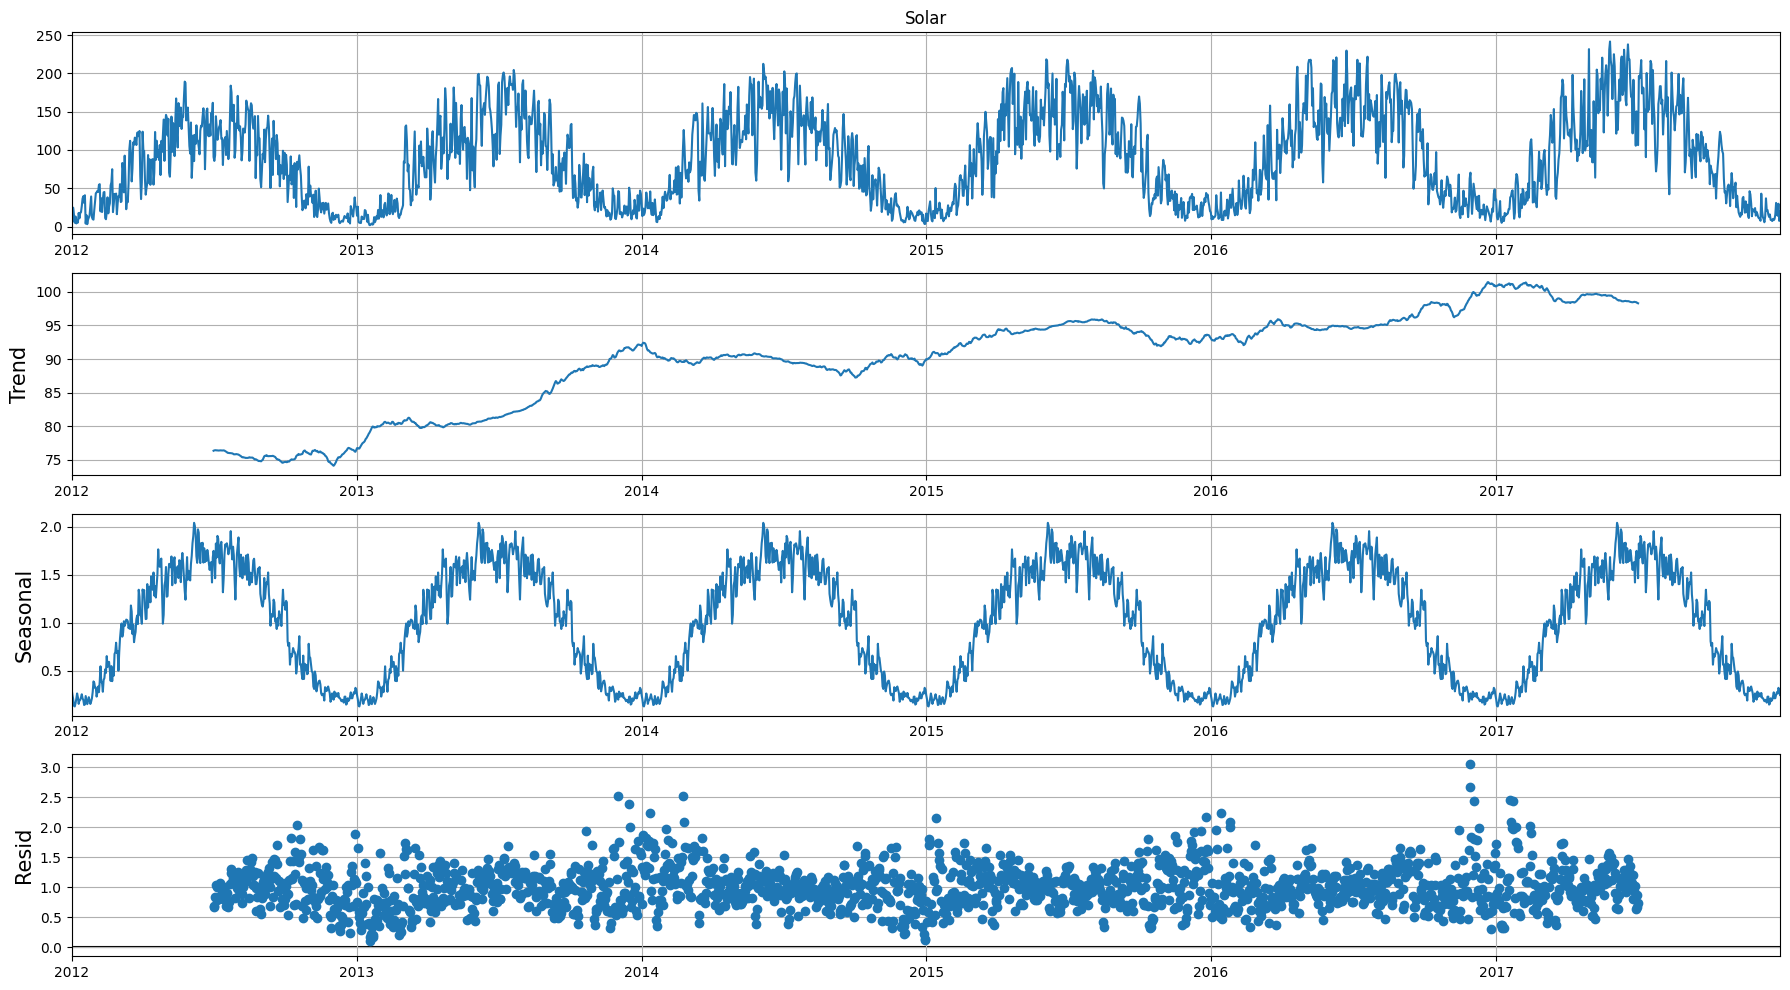

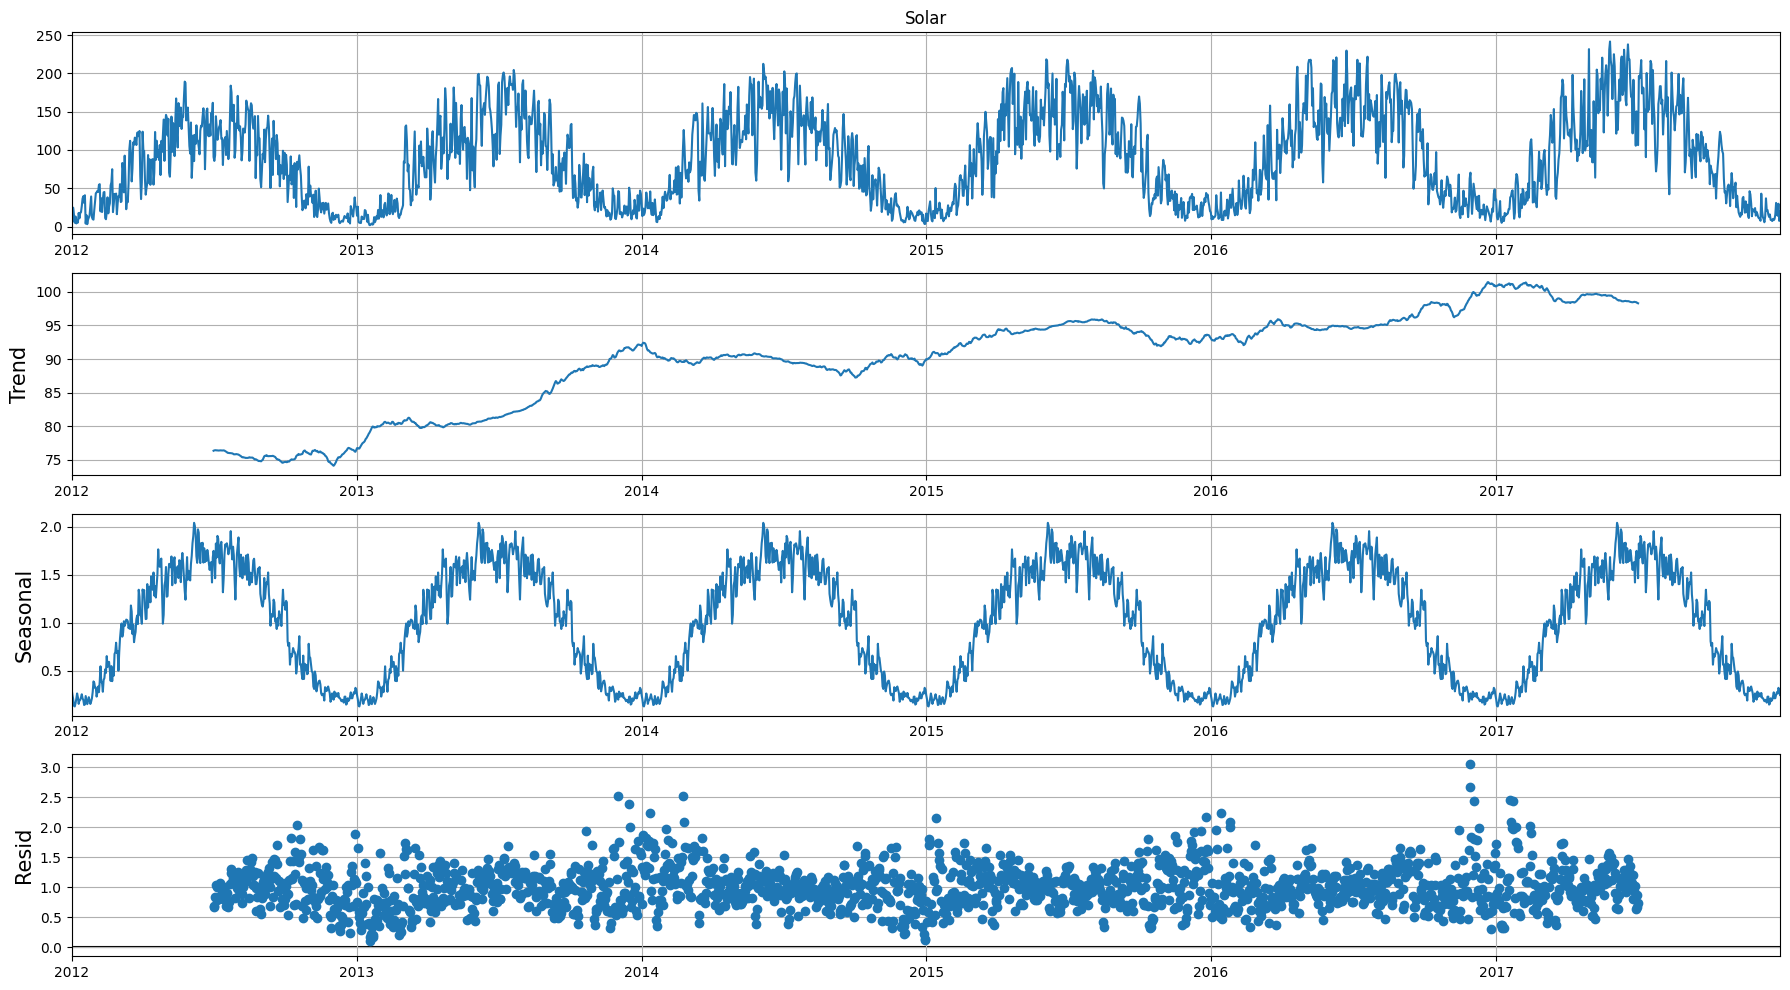

In [9]:
decomposition.plot()

<AxesSubplot: xlabel='resid', ylabel='Count'>

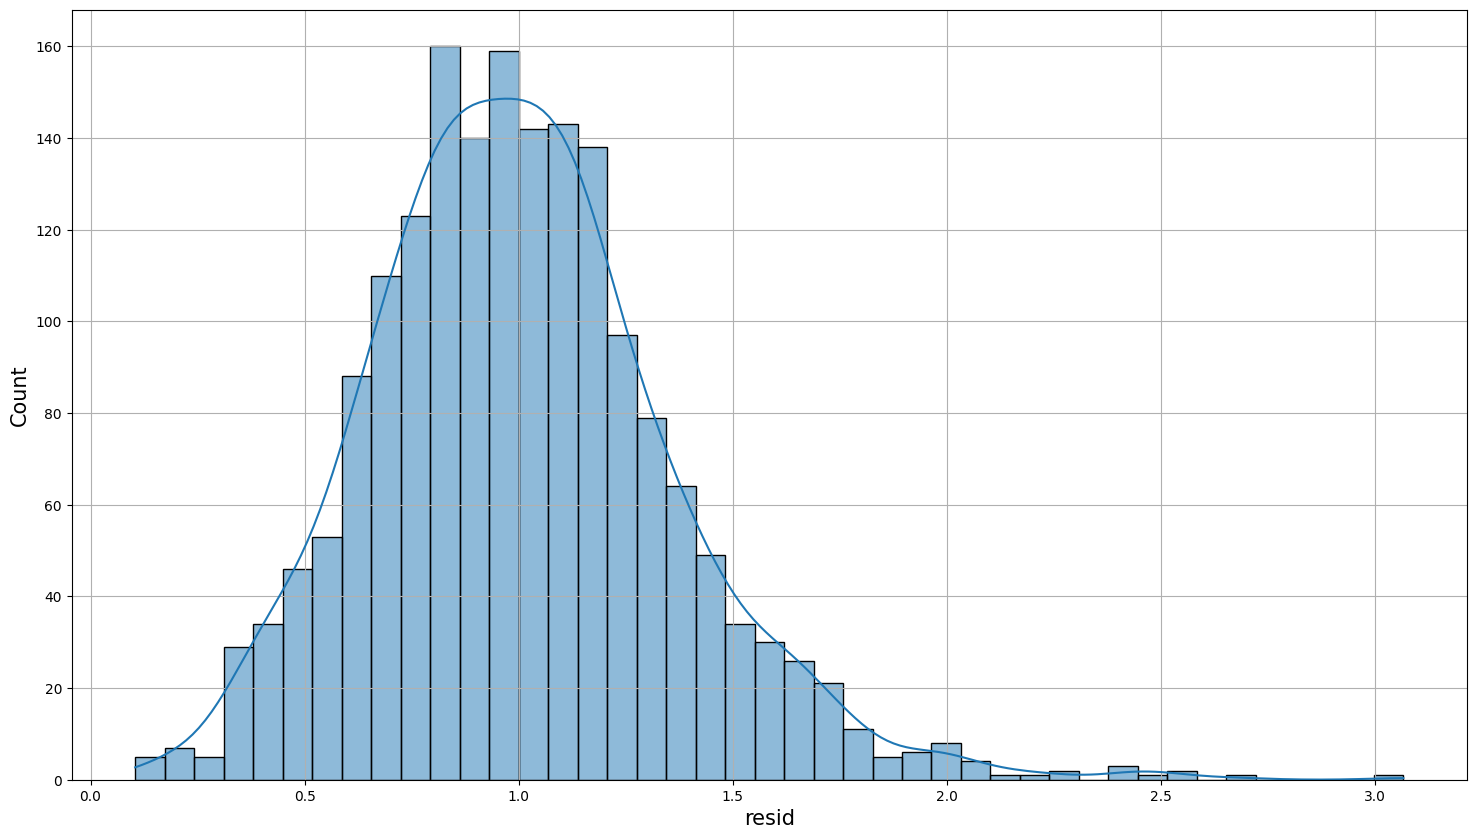

In [10]:
sns.histplot(decomposition.resid,kde = True)

Similar result, but I prefer additive

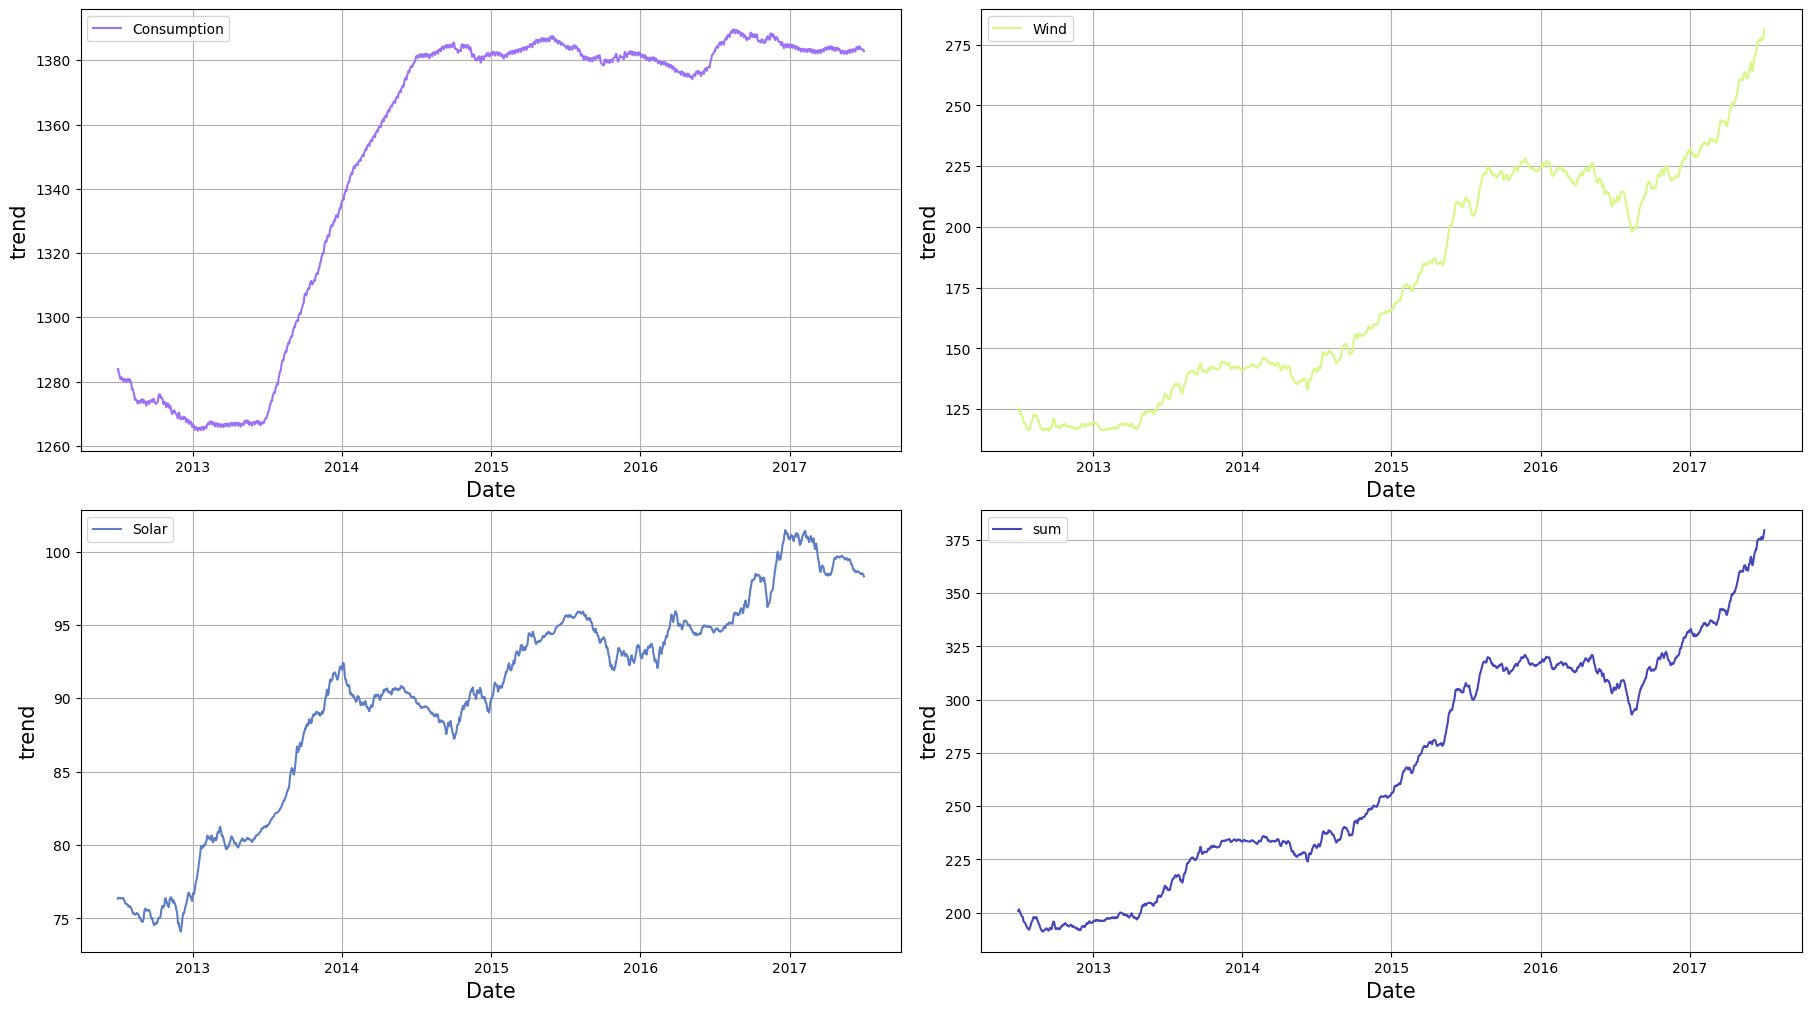

In [11]:
fig, axes = plt.subplots(2,2, constrained_layout = True)
df['sum'] = df['Solar'] + df['Wind']
for c, ax in zip(df.columns, axes.flatten()):

    decomposition = seasonal_decompose(df['2012':][c].fillna(method = 'ffill'), period = 365)
    sns.lineplot(decomposition.trend, ax = ax, label = c, color = np.random.random(3))
plt.legend()

<h1> Exercise 3 </h1>

In [12]:
alcohol = pd.read_csv('./datasets/alcohol_sales.csv', parse_dates=True, index_col='Date')
alcohol

Sales
Date             
1992-01-01   3459
1992-02-01   3458
1992-03-01   4002
1992-04-01   4564
1992-05-01   4221
...           ...
2019-08-01  14205
2019-09-01  12992
2019-10-01  14427
2019-11-01  13773
2019-12-01  16197

[336 rows x 1 columns]

In [13]:
alcohol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 1992-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   336 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


<AxesSubplot: xlabel='Date'>

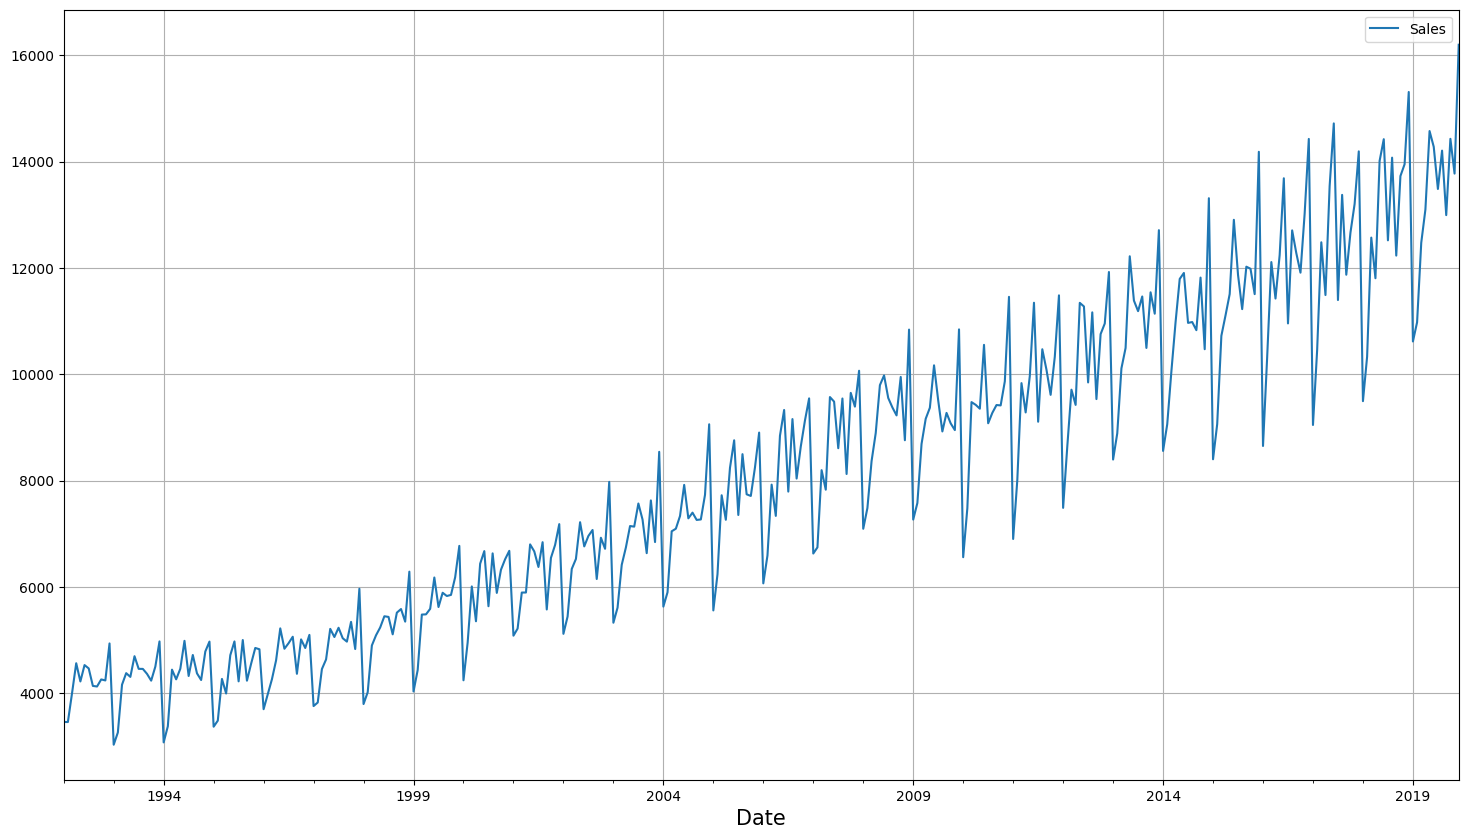

In [14]:
alcohol.plot()

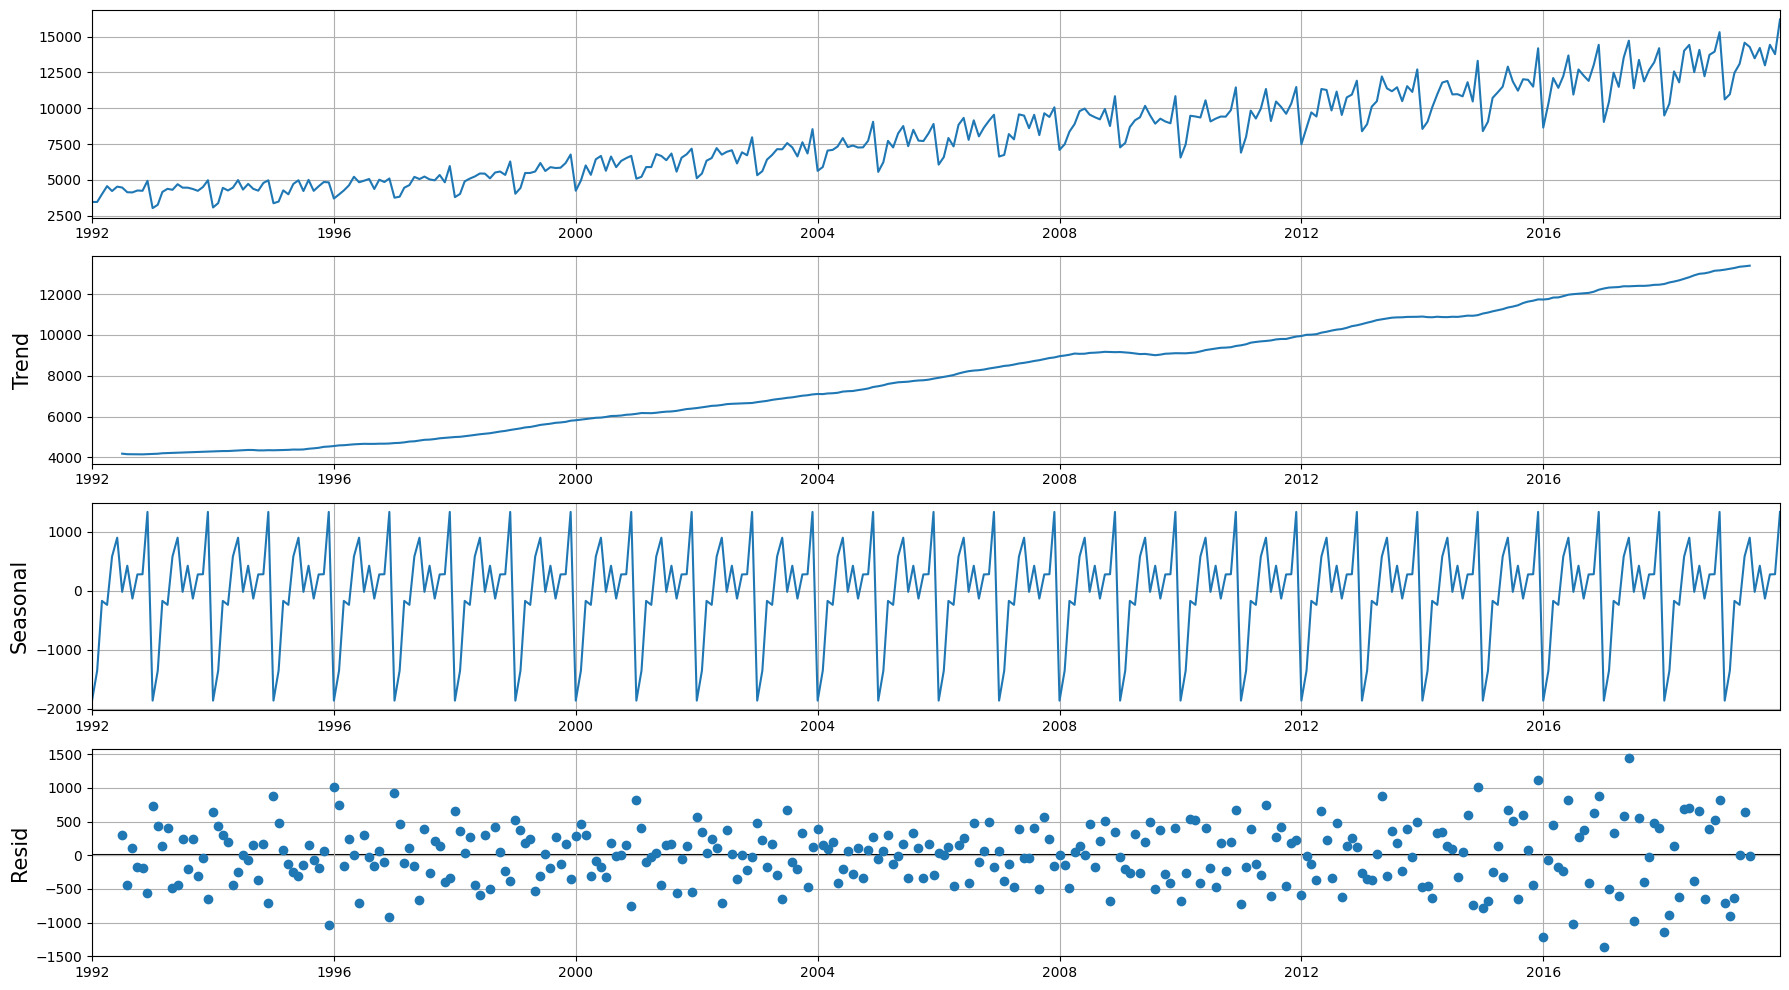

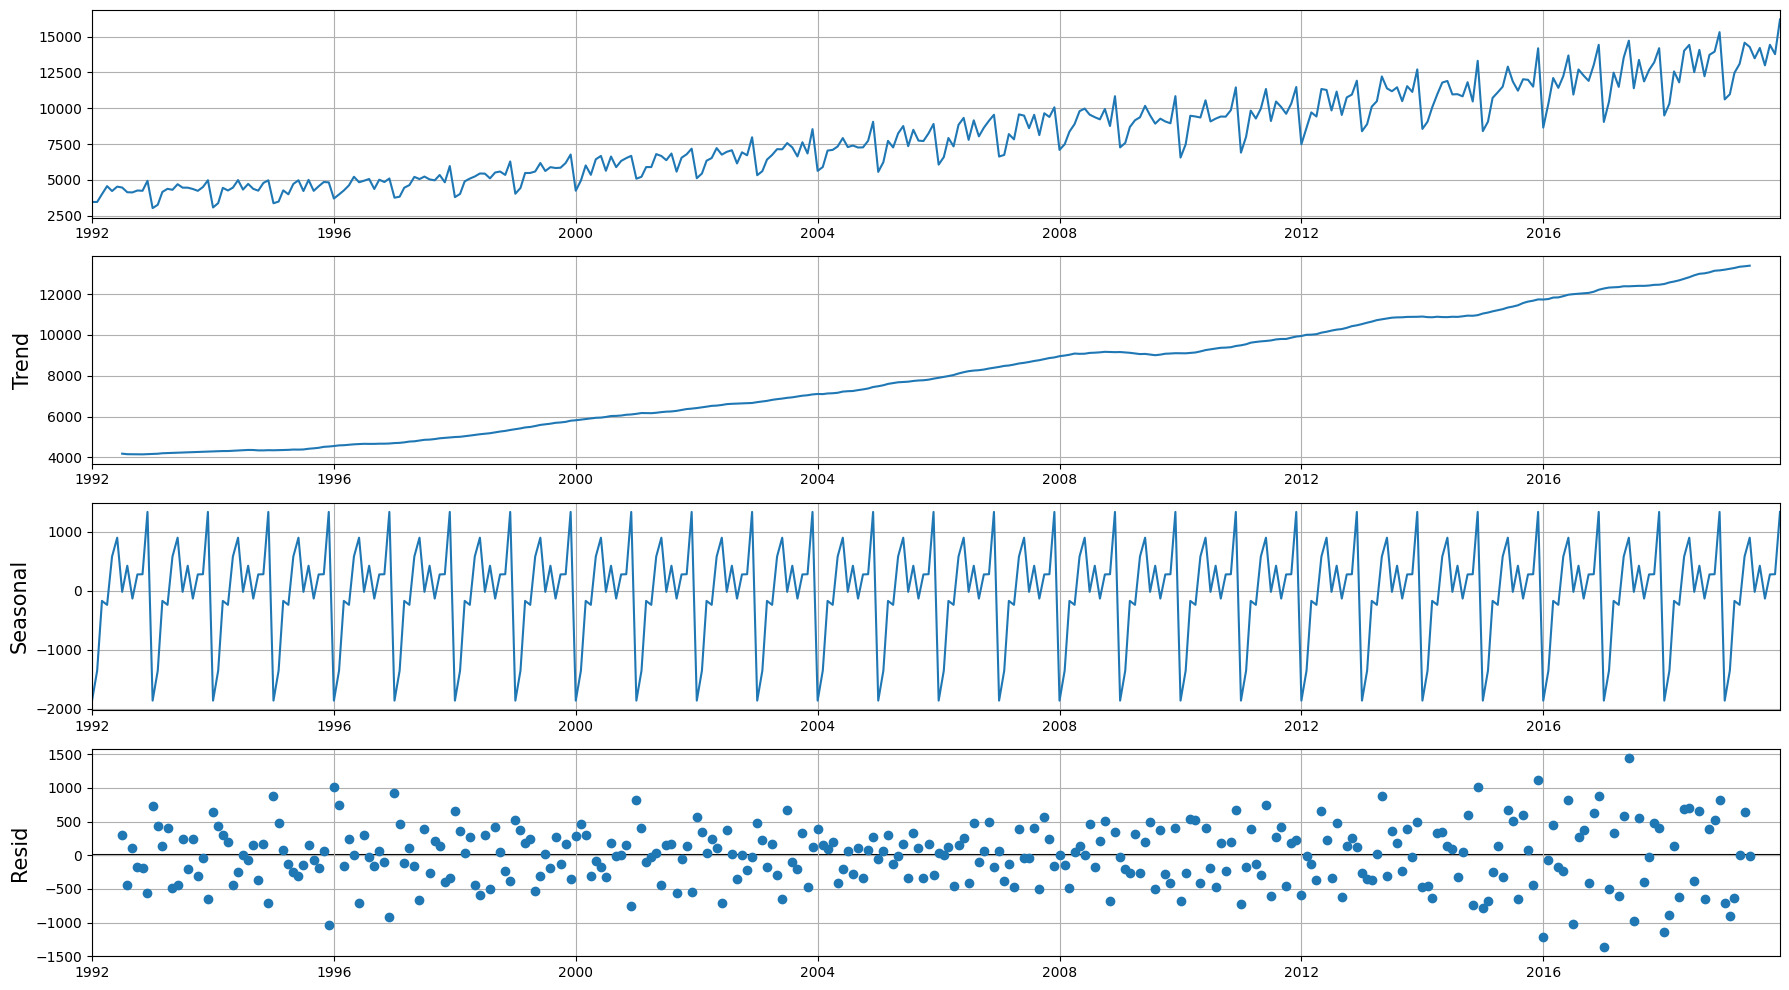

In [15]:
alc_decompostion = seasonal_decompose(alcohol, period=12)
alc_decompostion.plot()

The trend resemble a linear growth during the years.
<br> 
There is also a clear year seasonality with sub-seasonality which we will understand better in the next graph

<AxesSubplot: xlabel='Date'>

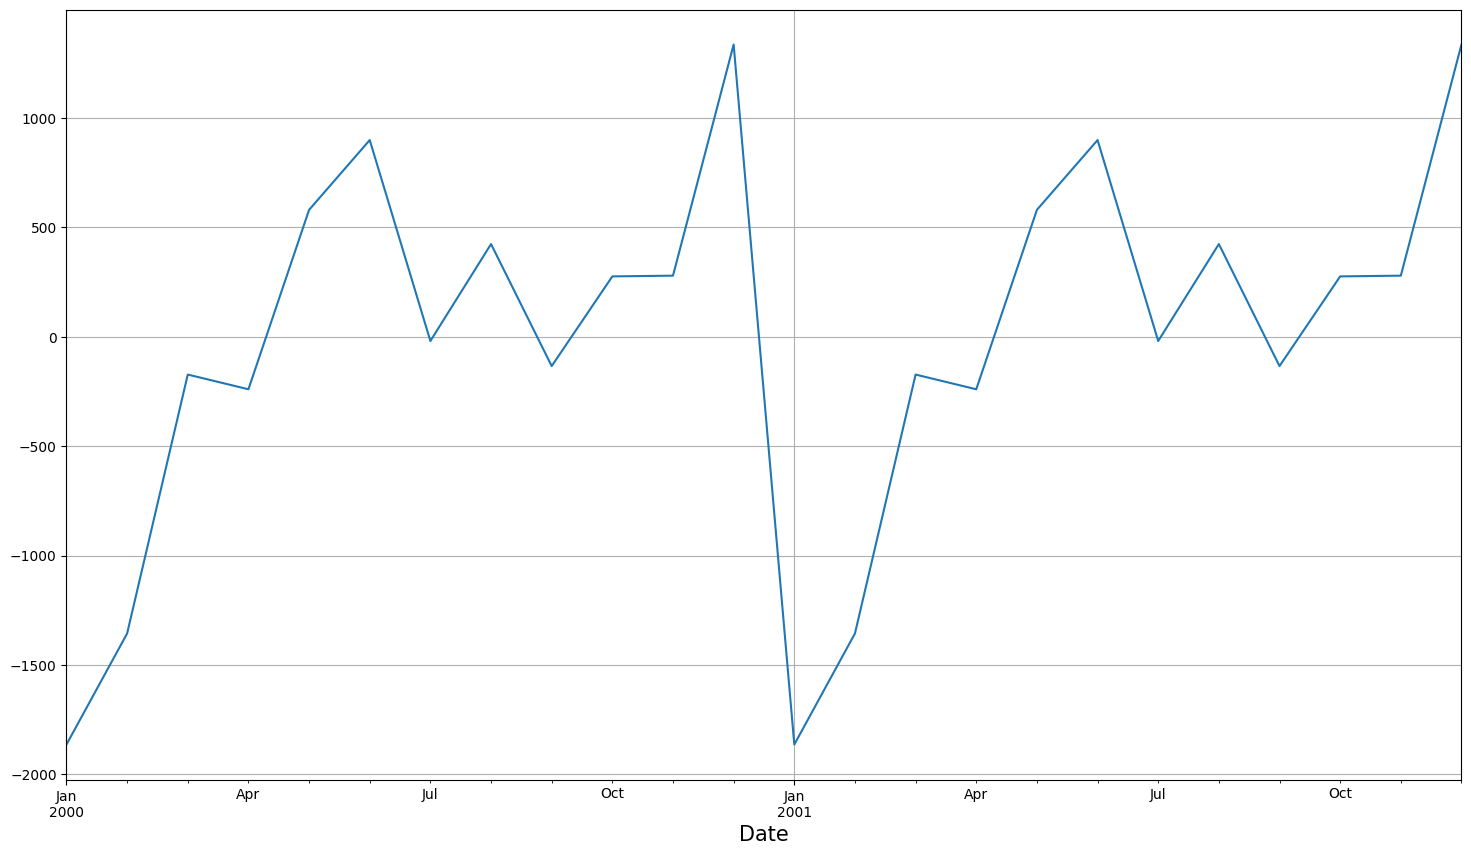

In [16]:
alc_decompostion.seasonal['2000':'2001'].plot()


There are two main peaks, one at the start of the summer and one in december. Probably these are due to parties at the start of the summer and christmas holidays, both events where people get drunk.

<AxesSubplot: xlabel='resid', ylabel='Count'>

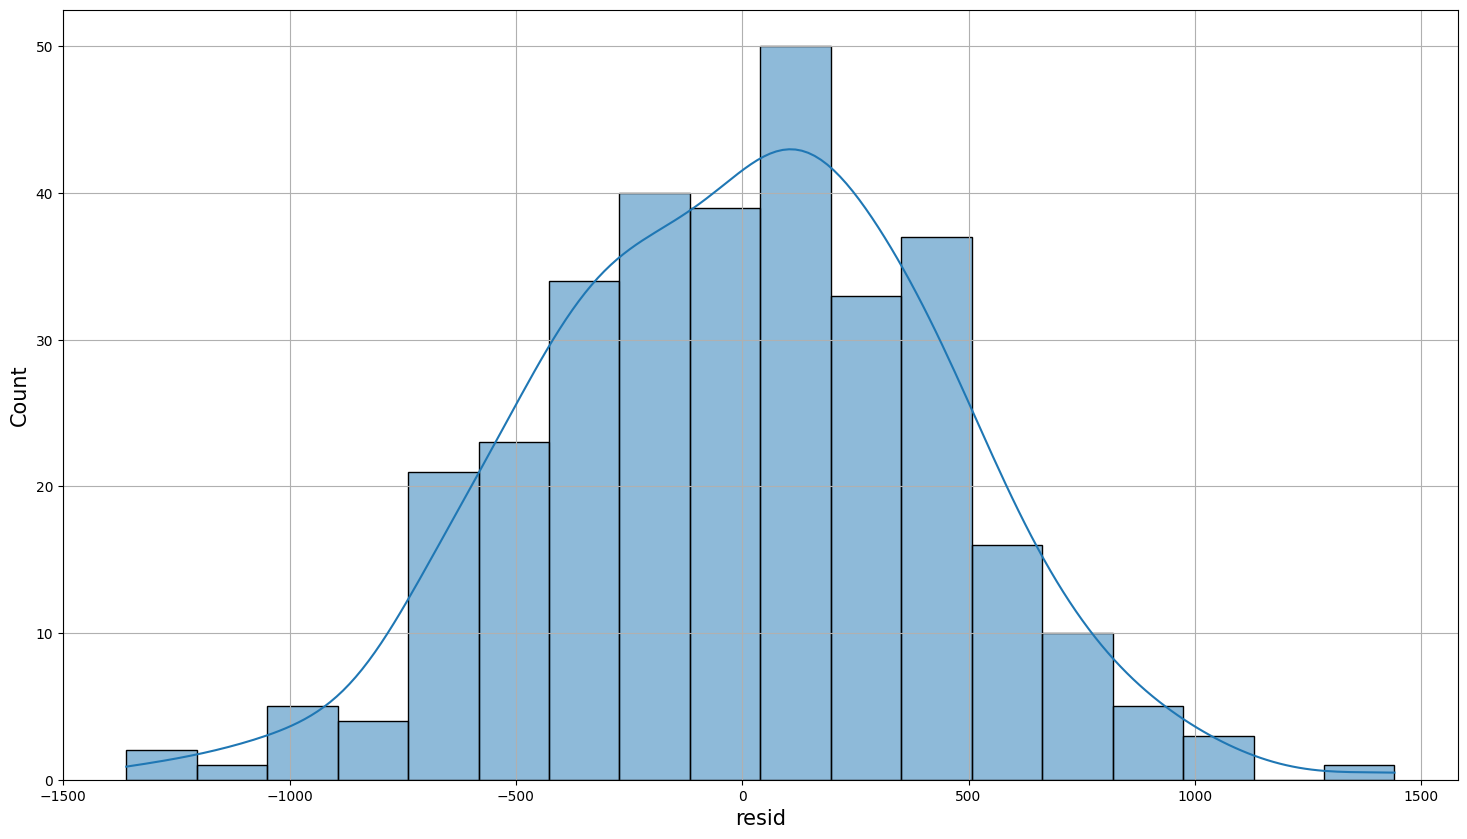

In [17]:
alc_res = alc_decompostion.resid
n_bins = int(np.sqrt(alc_res.dropna().shape[0]))
sns.histplot(alc_res.dropna(), bins = n_bins, kde = True)

The kde curve looks like the sum of two gaussian with differente mean.
<br>
Let's see the $\chi^2$ and the  $\chi^2$ test 

In [18]:
counts, bins = np.histogram(alc_res.dropna(), bins=n_bins)
chi = scipy.stats.chisquare(counts)
expected = alc_res.dropna().shape[0] -2
test = np.abs(expected - chi[0])/np.sqrt(2*expected)

display(Latex(f'expected $\chi^2$ value = {expected}, obtained $\chi^2$ value = {chi[0]}, p-value = {chi[1]}'))
print(f'Test = {test}')

<IPython.core.display.Latex object>

Test = 2.158546834865981


The test is barely acceptable, in terms of standard deviation on a $\chi^2$ distribution we are 2.16 sigma apart from the expected value

<h1> Exercise 4 </h1>

In [19]:
co2 = pd.read_csv('./datasets/co2-ppm-daily_csv.csv', parse_dates=True, index_col = 'date')
co2

value
date              
1958-03-30  316.16
1958-03-31  316.40
1958-04-02  317.67
1958-04-03  317.76
1958-04-04  317.09
...            ...
2020-08-30  411.90
2020-08-31  411.44
2020-09-01  411.93
2020-09-02  411.85
2020-09-03  411.69

[19419 rows x 1 columns]

In [20]:
co2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19419 entries, 1958-03-30 to 2020-09-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   19419 non-null  float64
dtypes: float64(1)
memory usage: 303.4 KB


<AxesSubplot: xlabel='date'>

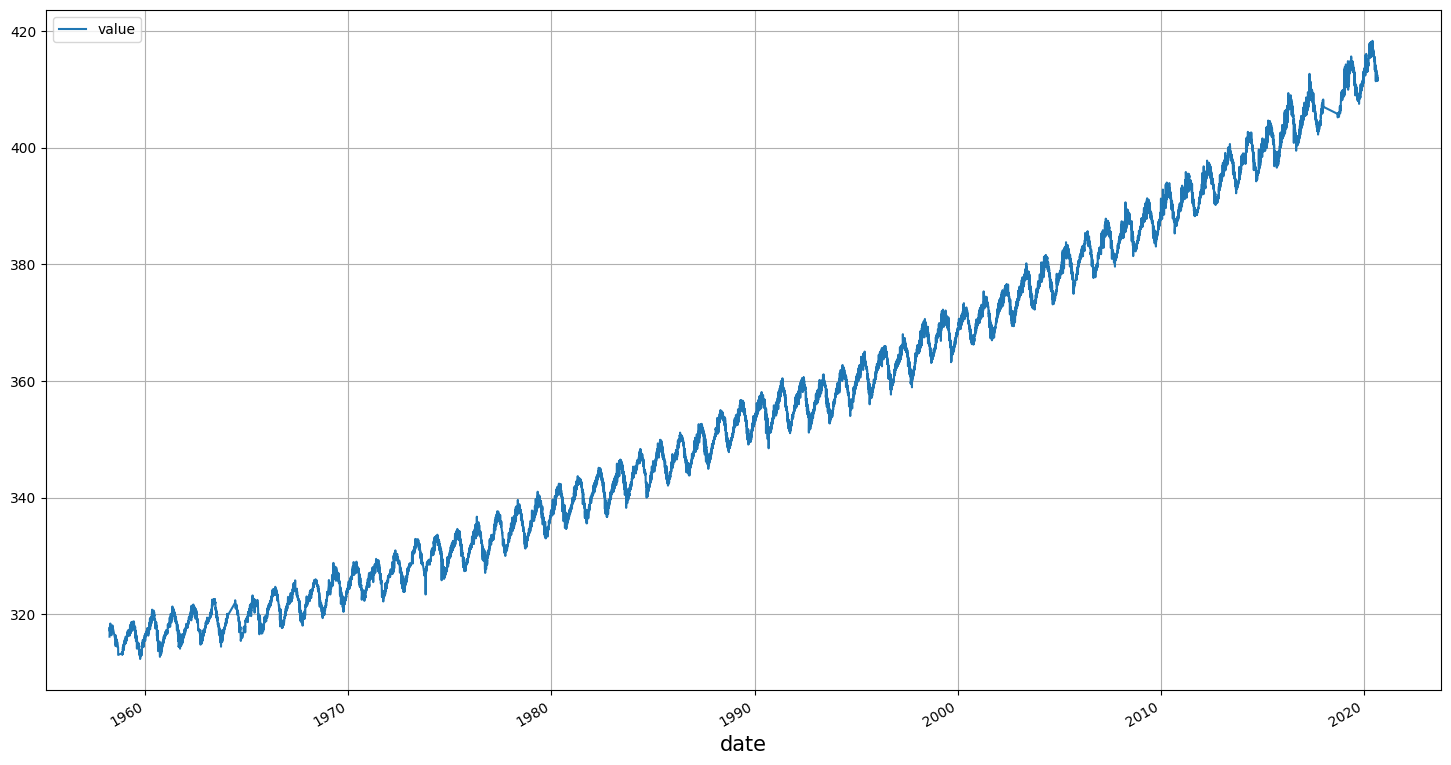

In [21]:
co2.plot()

<AxesSubplot: xlabel='date'>

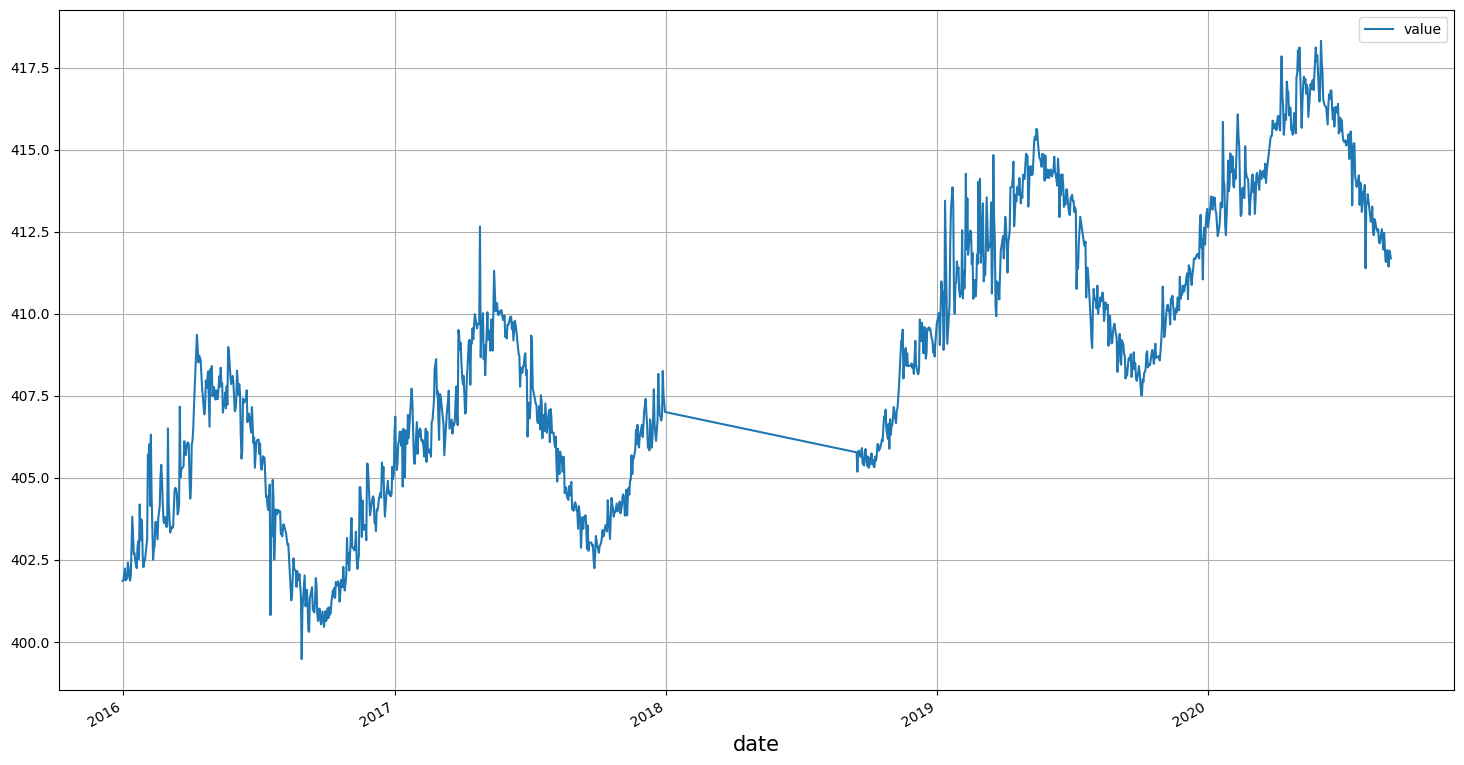

In [22]:
co2.loc['2016':'2021'].plot()

We can see that there are some missing dates during 2018

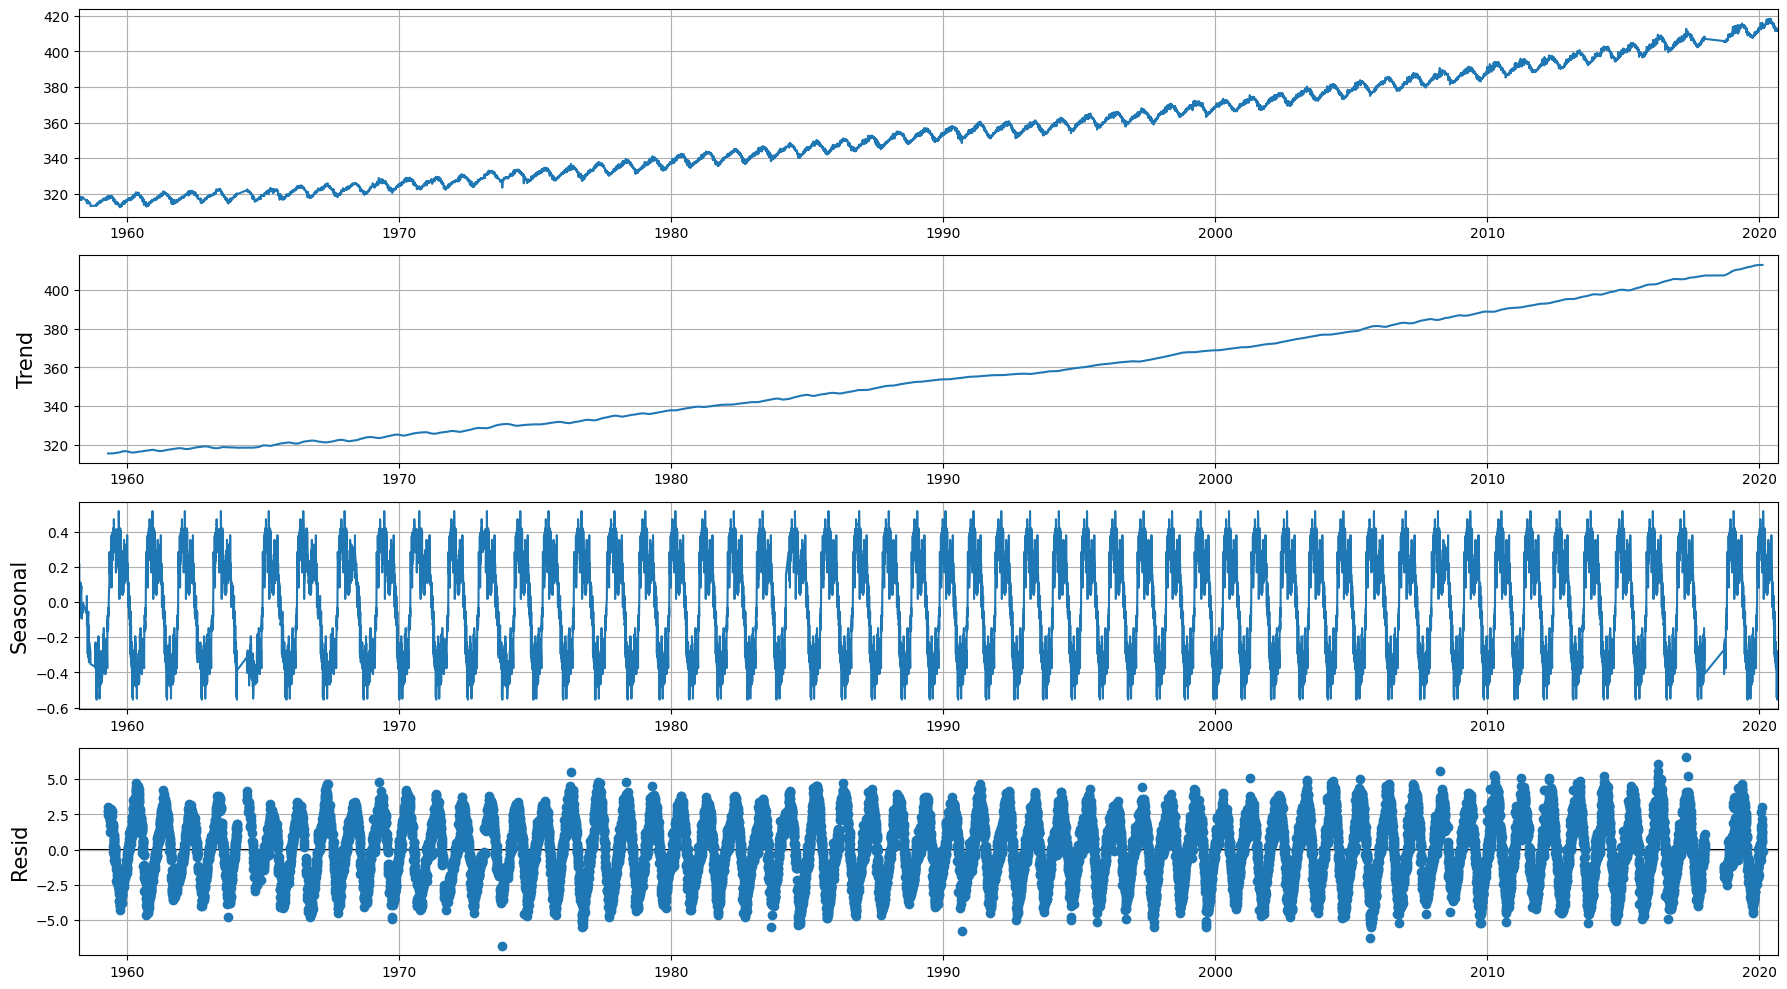

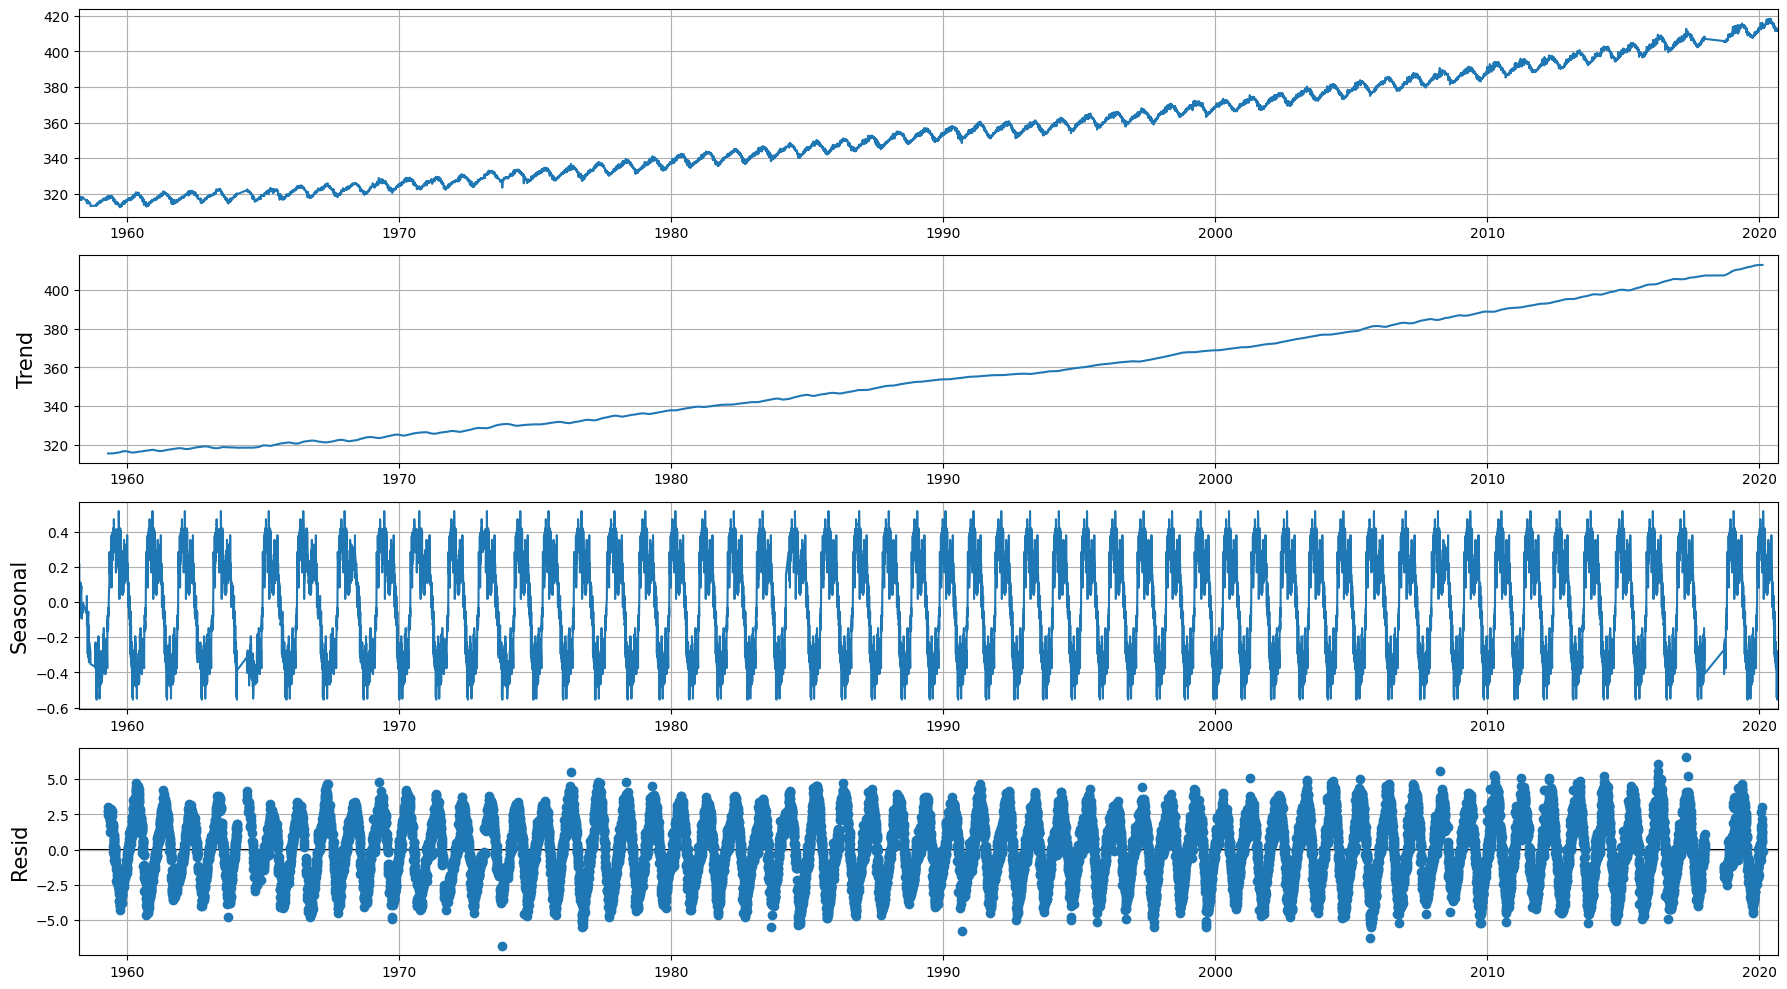

In [23]:
co2_dec = seasonal_decompose(co2, period=365)
co2_dec.plot()

<AxesSubplot: xlabel='resid', ylabel='Count'>

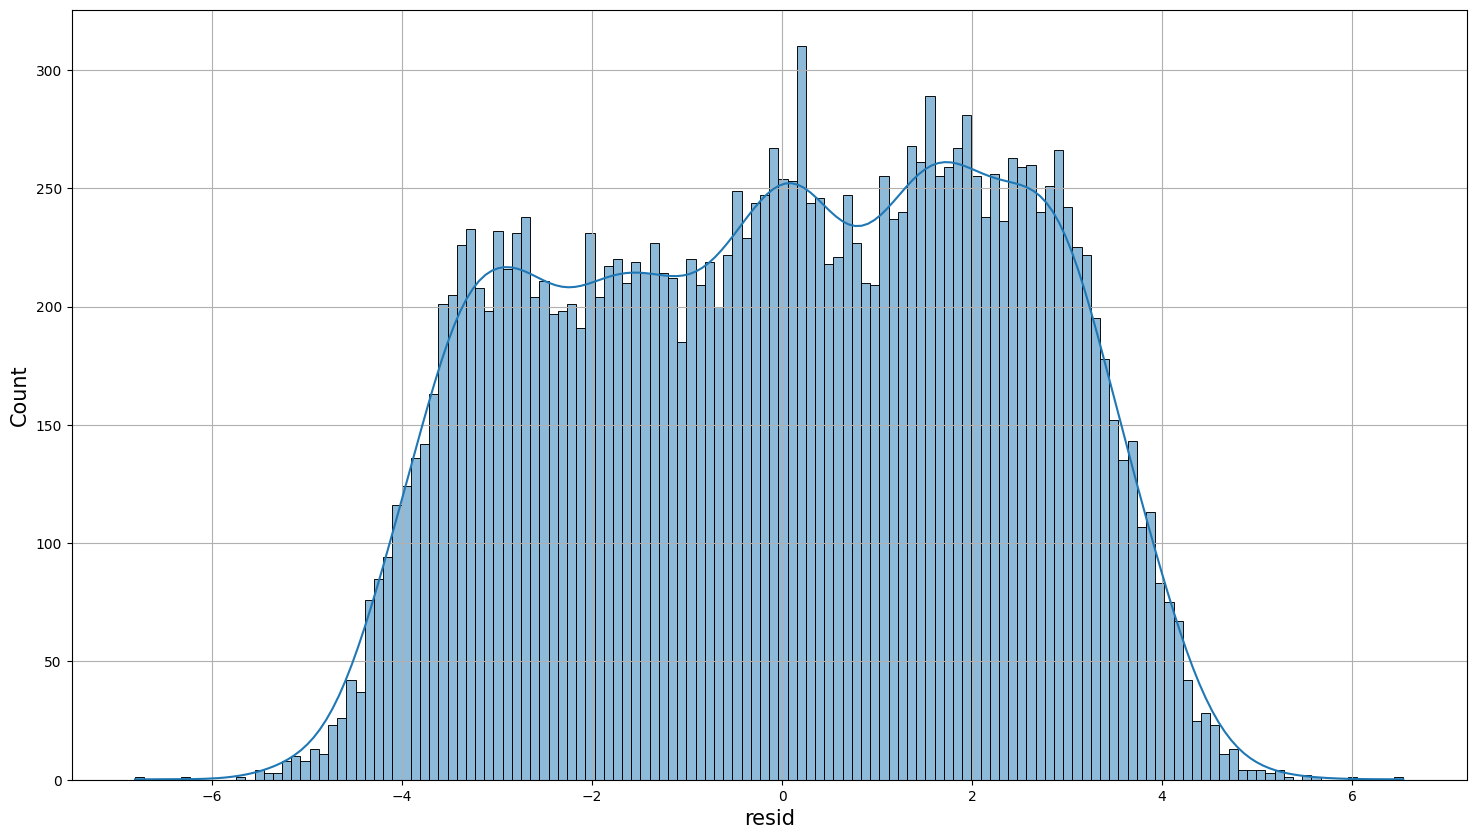

In [24]:
co2_res = co2_dec.resid
n_bins = int(np.sqrt(co2_res.dropna().shape[0]))
sns.histplot(co2_res.dropna(), bins = n_bins, kde = True)

Clearly this is not a normal distribution

In [25]:
counts, bins = np.histogram(co2_res.dropna(), bins=n_bins)
chi = scipy.stats.chisquare(counts)
expected = co2_res.dropna().shape[0] -2
test = np.abs(expected - chi[0])/np.sqrt(2*expected)

display(Latex(f'expected $\chi^2$ value = {expected}, obtained $\chi^2$ value = {chi[0]}, p-value = {chi[1]}'))
print(f'Test = {test}')

<IPython.core.display.Latex object>

Test = 40.053733415637865


<h1> Exercise 5 </h1>

As we saw in previous decompositions, distribution of residuals of solar energy production series is not a gaussian, so we won't applay a SARIMA model

In [26]:
solar = df[['Solar']]
solar.loc['2012':].fillna(method='ffill', inplace = True)
#solar = solar.resample('W').mean()

train = solar.loc['2012':'2016']
test = solar.loc['2017']
    
prophet_train = train.reset_index()
prophet_train.columns = ['ds','y']
prophet = Prophet(changepoint_prior_scale=0.5, seasonality_mode='additive')
prophet.fit(prophet_train)
solar

C:\Users\ggiam\AppData\Local\Temp\ipykernel_4728\417430003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar.loc['2012':].fillna(method='ffill', inplace = True)
21:11:57 - cmdstanpy - INFO - Chain [1] start processing
21:11:58 - cmdstanpy - INFO - Chain [1] done processing


Solar
Date              
2006-01-01     NaN
2006-01-02     NaN
2006-01-03     NaN
2006-01-04     NaN
2006-01-05     NaN
...            ...
2017-12-27  16.530
2017-12-28  14.162
2017-12-29  29.854
2017-12-30   7.467
2017-12-31  19.980

[4383 rows x 1 columns]

0.31063781272667723

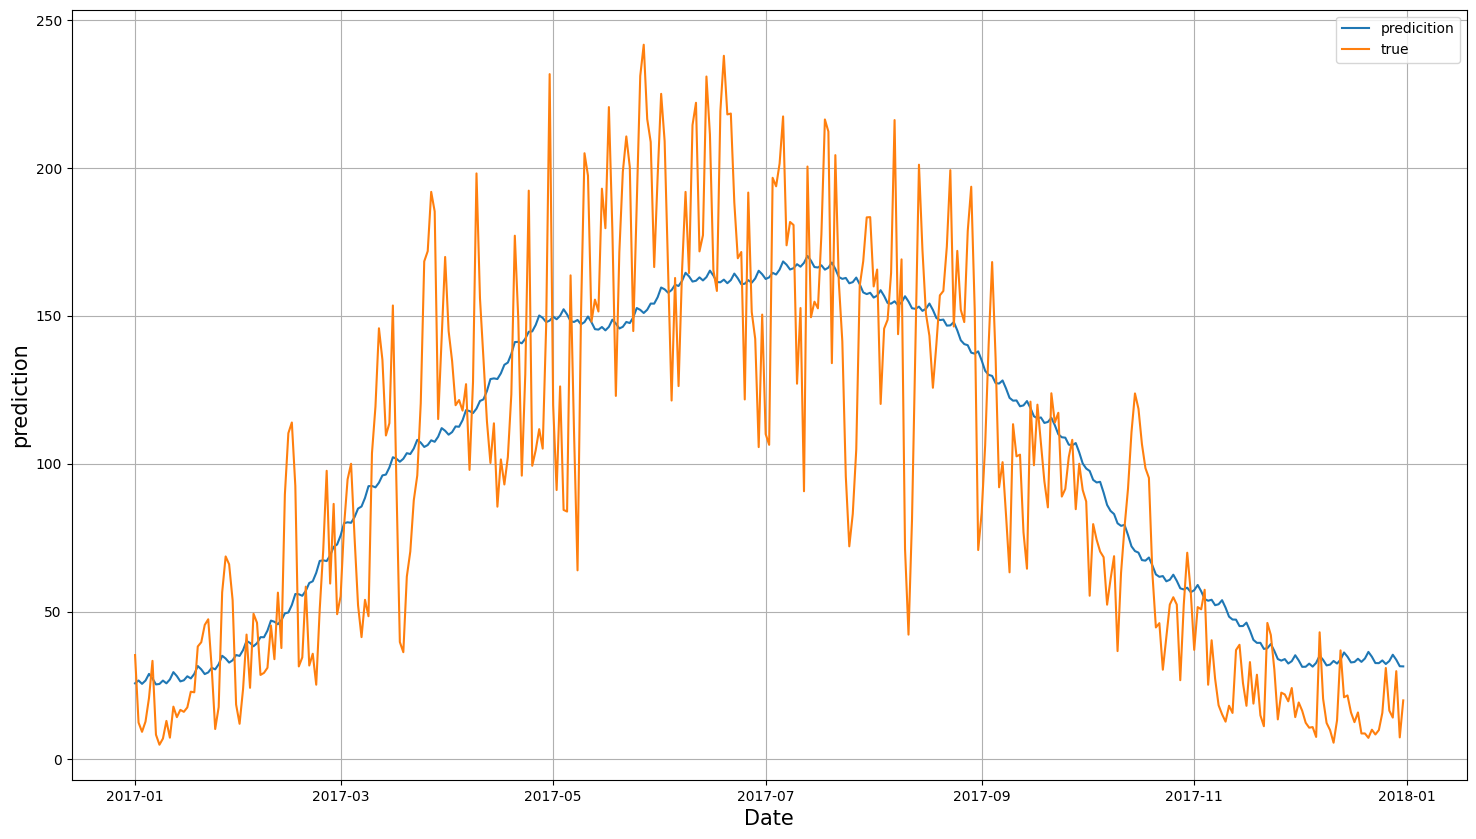

In [27]:
future = prophet.make_future_dataframe(periods=test.shape[0], include_history=False)
predictions = prophet.predict(future)
test['prediction'] = predictions.yhat.values
sns.lineplot(test['prediction'], label = 'predicition')
sns.lineplot(test['Solar'], label = 'true')
plt.legend()
mean_absolute_percentage_error(test['prediction'], test['Solar'])

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy

In [29]:
window_size = 30
train = solar.loc['2012':'2017']
test_size = train.loc['2017'].shape[0]/train.shape[0]

X, Y = [], []

for i in range(window_size, train.shape[0]):
    X.append(train.values[i-window_size:i, 0])
    Y.append(train.values[i, 0])
    
X_train, X_test, Y_train, Y_test = X[:-365], X[-365:], Y[:-365], Y[-365:],
    
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32') 
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')
    
mean = X_train[-1].mean()
std= X_train[-1].std()

X_train_scaled = (X_train - mean)/std
X_test_scaled = (X_test - mean)/std
Y_train_scaled = (Y_train - mean)/std
Y_test_scaled = (Y_test - mean)/std

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0],1,30,1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0],1,30,1)

In [30]:
def cnn_lstm(i):
    
    model = tf.keras.Sequential()
    
    #CNN layers
    model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='elu', input_shape=(None, window_size, 1))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
#    model.add(Dense(5, kernel_regularizer=L2(0.01)))

    # LSTM layers
    model.add(Bidirectional(LSTM(i, return_sequences=False)))

    #Final layers
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Adamax', loss='mae', metrics=['mse', 'mae'])

    return model

In [31]:
model = cnn_lstm(window_size)
model.fit(X_train_scaled, Y_train_scaled, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
57/57 [==============================] - 3s 5ms/step - loss: 2.3388 - mse: 10.0972 - mae: 2.3388
Epoch 2/25
57/57 [==============================] - 0s 4ms/step - loss: 1.9456 - mse: 6.7221 - mae: 1.9456
Epoch 3/25
57/57 [==============================] - 0s 5ms/step - loss: 1.8294 - mse: 5.9580 - mae: 1.8294
Epoch 4/25
57/57 [==============================] - 0s 5ms/step - loss: 1.7851 - mse: 5.6461 - mae: 1.7851
Epoch 5/25
57/57 [==============================] - 0s 5ms/step - loss: 1.7038 - mse: 5.1948 - mae: 1.7038
Epoch 6/25
57/57 [==============================] - 0s 5ms/step - loss: 1.6712 - mse: 5.0169 - mae: 1.6712
Epoch 7/25
57/57 [==============================] - 0s 5ms/step - loss: 1.6409 - mse: 4.8176 - mae: 1.6409
Epoch 8/25
57/57 [==============================] - 0s 5ms/step - loss: 1.6165 - mse: 4.7304 - mae: 1.6165
Epoch 9/25
57/57 [==============================] - 0s 5ms/step - loss: 1.6084 - mse: 4.7067 - mae: 1.6084
Epoch 10/25
57/57 [=================

12/12 [==============================] - 1s 3ms/step


(22.303238, 0.2829841)

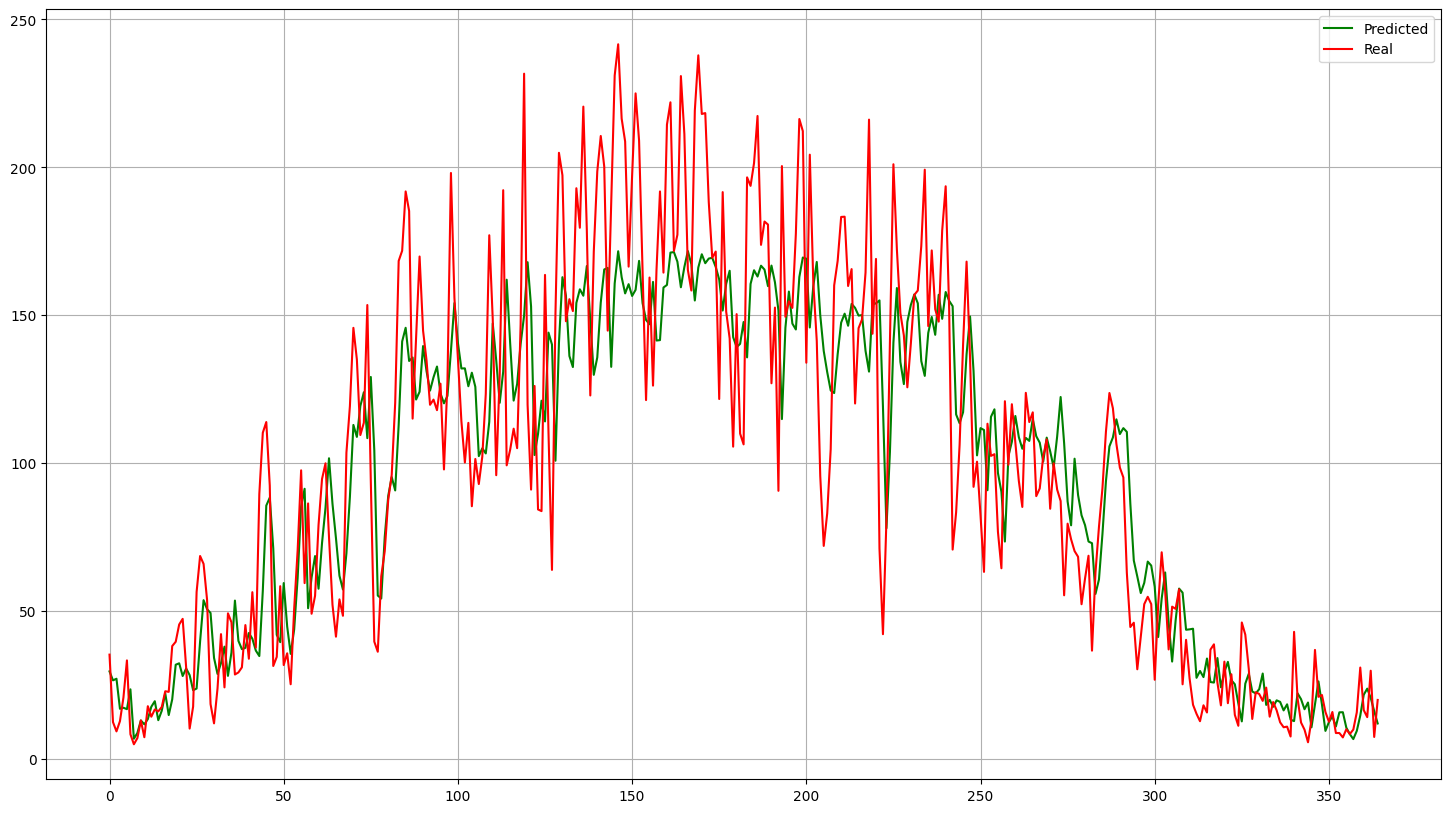

In [32]:
predicted  = model.predict(X_test_scaled).flatten()
true = Y_test_scaled.flatten()

predicted = np.array(predicted) * std + mean
true = true * std + mean

plt.plot(predicted, color = 'green', label = 'Predicted')
plt.plot(true, color = 'red', label = 'Real')
plt.legend()
mean_absolute_error(predicted, true), mean_absolute_percentage_error(predicted, true)

<h1> Exercise 6 </h1>

In [33]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
data = pd.read_csv(url, parse_dates=True, index_col = 'data')
data

stato  ricoverati_con_sintomi  terapia_intensiva  \
data                                                                   
2020-02-24 18:00:00   ITA                     101                 26   
2020-02-25 18:00:00   ITA                     114                 35   
2020-02-26 18:00:00   ITA                     128                 36   
2020-02-27 18:00:00   ITA                     248                 56   
2020-02-28 18:00:00   ITA                     345                 64   
...                   ...                     ...                ...   
2022-10-16 17:00:00   ITA                    6715                252   
2022-10-17 17:00:00   ITA                    6928                254   
2022-10-18 17:00:00   ITA                    6993                254   
2022-10-19 17:00:00   ITA                    7062                251   
2022-10-20 17:00:00   ITA                    7025                242   

                     totale_ospedalizzati  isolamento_domiciliare  \
data                                                                
2020-02-24 18:00:00                   127                      94   
2020-02-25 18:00:00                   150                     162   
2020-02-26 18:00:00                   164                     221   
2020-02-27 18:00:00                   304                     284   
2020-02-28 18:00:00                   409                     412   
...                                   ...                     ...   
2022-10-16 17:00:00                  6967                  546047   
2022-10-17 17:00:00                  7182                  536906   
2022-10-18 17:00:00                  7247                  535960   
2022-10-19 17:00:00                  7313                  535479   
2022-10-20 17:00:00                  7267                  527409   

                     totale_positivi  variazione_totale_positivi  \
data                                                               
2020-02-24 18:00:00              221                           0   
2020-02-25 18:00:00              311                          90   
2020-02-26 18:00:00              385                          74   
2020-02-27 18:00:00              588                         203   
2020-02-28 18:00:00              821                         233   
...                              ...                         ...   
2022-10-16 17:00:00           553014                         522   
2022-10-17 17:00:00           544088                       -8926   
2022-10-18 17:00:00           543207                        -881   
2022-10-19 17:00:00           542792                        -415   
2022-10-20 17:00:00           534676                       -8116   

                     nuovi_positivi  dimessi_guariti  deceduti  ...  \
data                                                            ...   
2020-02-24 18:00:00             221                1         7  ...   
2020-02-25 18:00:00              93                1        10  ...   
2020-02-26 18:00:00              78                3        12  ...   
2020-02-27 18:00:00             250               45        17  ...   
2020-02-28 18:00:00             238               46        21  ...   
...                             ...              ...       ...  ...   
2022-10-16 17:00:00           30239         22368981    177988  ...   
2022-10-17 17:00:00           13439         22391844    178081  ...   
2022-10-18 17:00:00           58360         22450969    178194  ...   
2022-10-19 17:00:00           41712         22493006    178275  ...   
2022-10-20 17:00:00           40563         22541598    178359  ...   

                       tamponi  casi_testati  note  \
data                                                 
2020-02-24 18:00:00       4324           NaN   NaN   
2020-02-25 18:00:00       8623           NaN   NaN   
2020-02-26 18:00:00       9587           NaN   NaN   
2020-02-27 18:00:00      12014           NaN   NaN   
2020-02-28 18:00:00      15695           NaN   NaN  

In [34]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 970 entries, 2020-02-24 18:00:00 to 2022-10-20 17:00:00
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   stato                                   970 non-null    object 
 1   ricoverati_con_sintomi                  970 non-null    int64  
 2   terapia_intensiva                       970 non-null    int64  
 3   totale_ospedalizzati                    970 non-null    int64  
 4   isolamento_domiciliare                  970 non-null    int64  
 5   totale_positivi                         970 non-null    int64  
 6   variazione_totale_positivi              970 non-null    int64  
 7   nuovi_positivi                          970 non-null    int64  
 8   dimessi_guariti                         970 non-null    int64  
 9   deceduti                                970 non-null    int64  
 10  casi_da_sospetto_diagnost

stato                                       0
ricoverati_con_sintomi                      0
terapia_intensiva                           0
totale_ospedalizzati                        0
isolamento_domiciliare                      0
totale_positivi                             0
variazione_totale_positivi                  0
nuovi_positivi                              0
dimessi_guariti                             0
deceduti                                    0
casi_da_sospetto_diagnostico              808
casi_da_screening                         808
totale_casi                                 0
tamponi                                     0
casi_testati                               55
note                                      926
ingressi_terapia_intensiva                283
note_test                                 970
note_casi                                 970
totale_positivi_test_molecolare           326
totale_positivi_test_antigenico_rapido    326
tamponi_test_molecolare           

In [35]:
partial = data[['ricoverati_con_sintomi','nuovi_positivi','deceduti']]
partial

ricoverati_con_sintomi  nuovi_positivi  deceduti
data                                                                 
2020-02-24 18:00:00                     101             221         7
2020-02-25 18:00:00                     114              93        10
2020-02-26 18:00:00                     128              78        12
2020-02-27 18:00:00                     248             250        17
2020-02-28 18:00:00                     345             238        21
...                                     ...             ...       ...
2022-10-16 17:00:00                    6715           30239    177988
2022-10-17 17:00:00                    6928           13439    178081
2022-10-18 17:00:00                    6993           58360    178194
2022-10-19 17:00:00                    7062           41712    178275
2022-10-20 17:00:00                    7025           40563    178359

[970 rows x 3 columns]

<AxesSubplot: xlabel='data'>

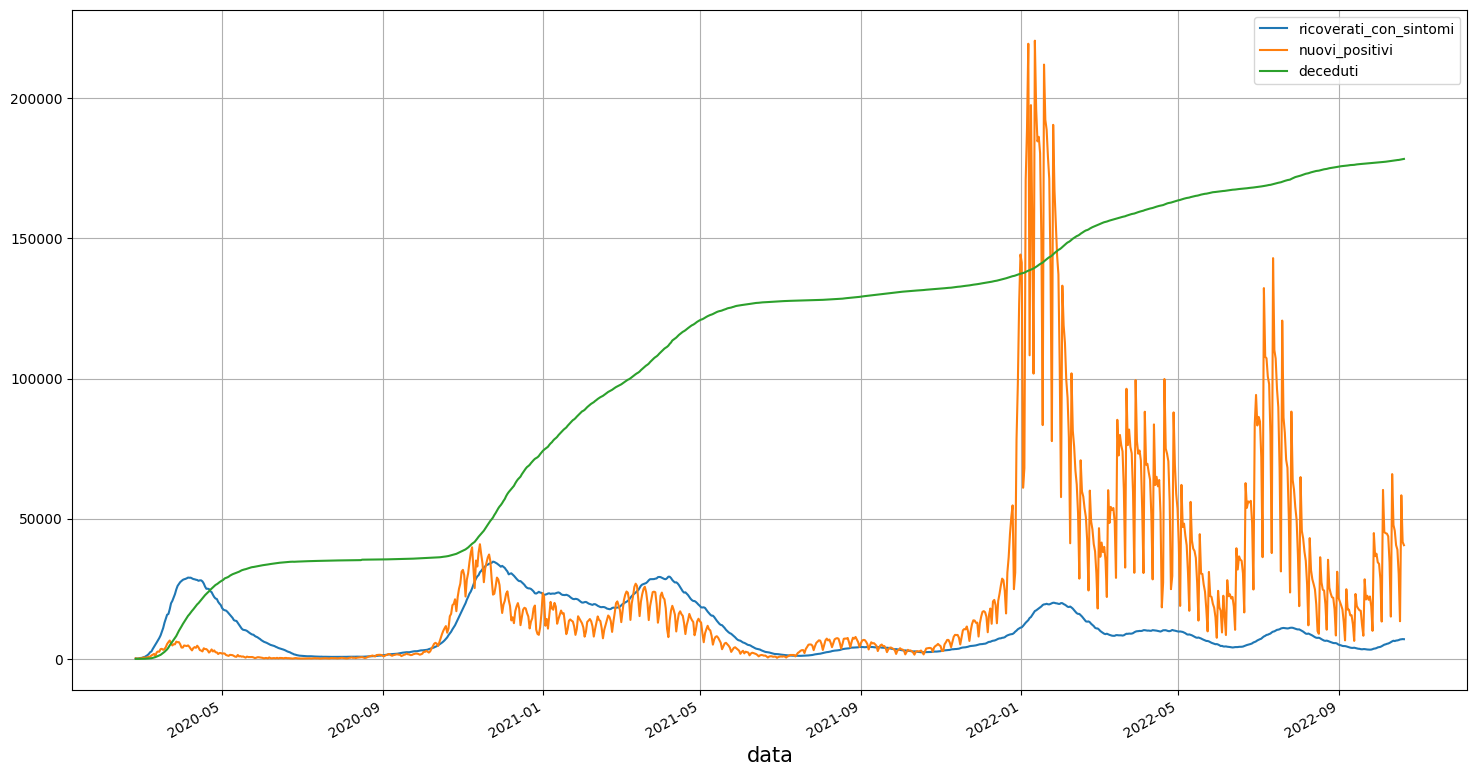

In [36]:
partial.plot()

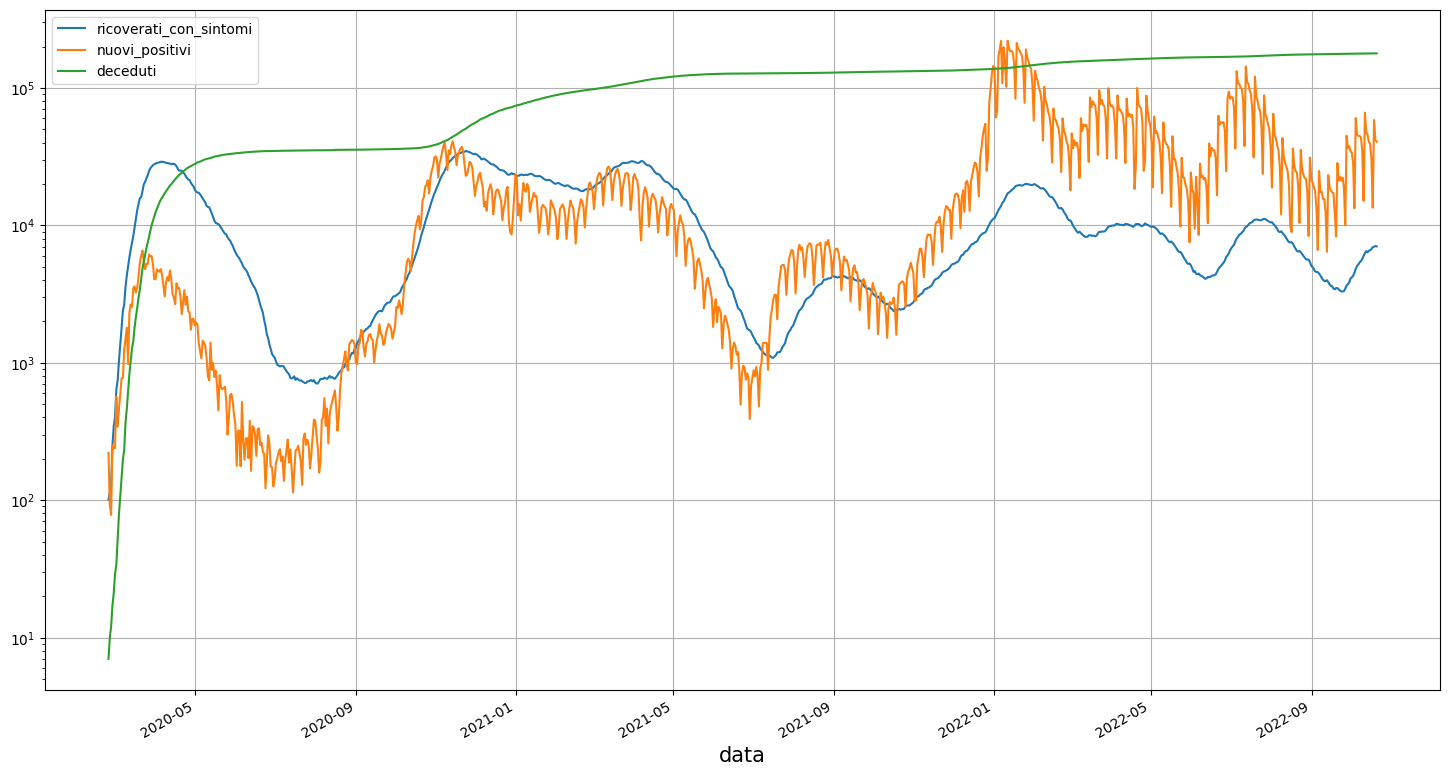

In [37]:
partial.plot()
plt.yscale('log')

Text(0, 0.5, 'Nuovi Positivi')

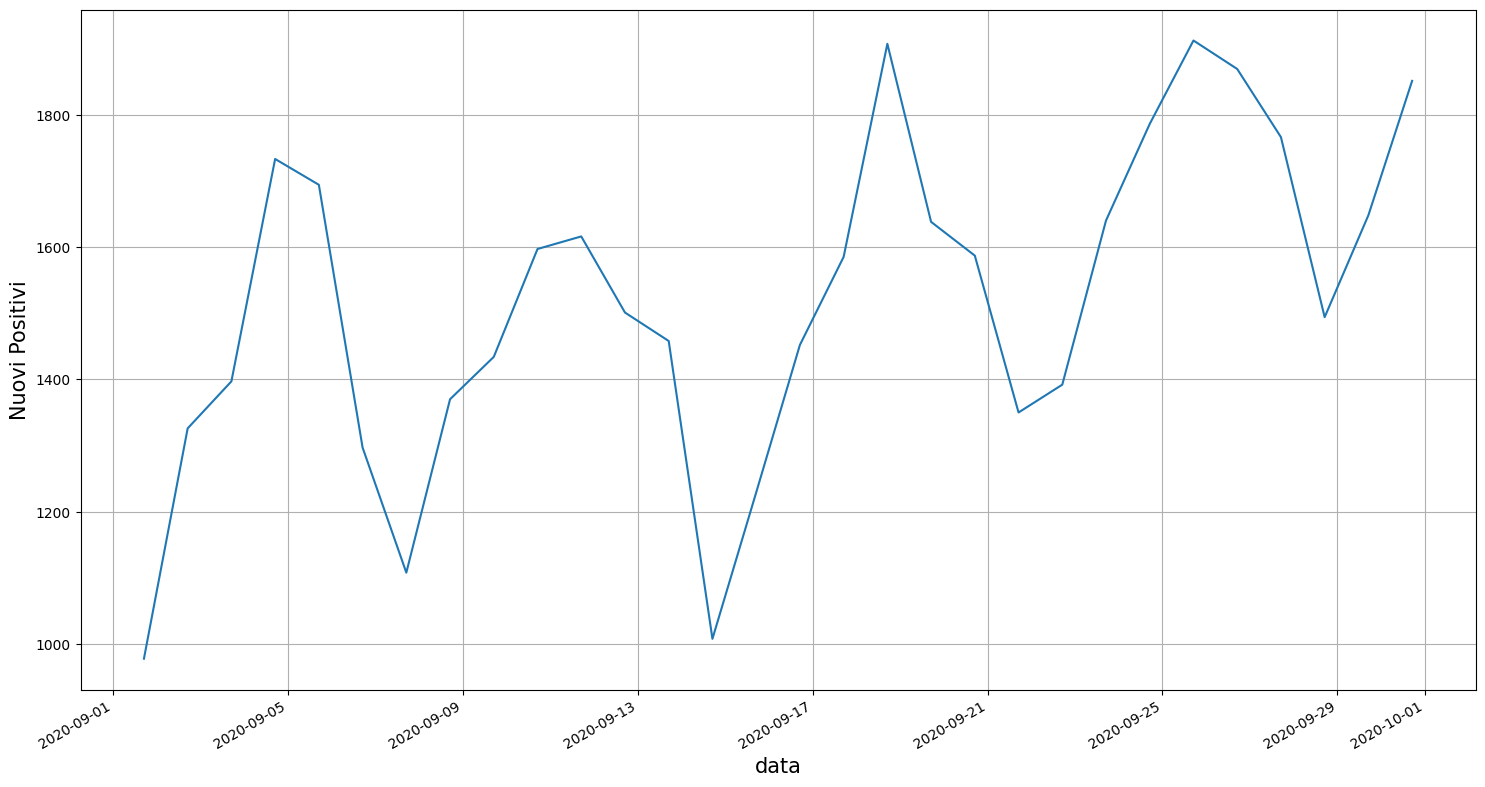

In [38]:
partial.loc['2020-09','nuovi_positivi'].plot()
plt.ylabel('Nuovi Positivi')

From logscale one can say that deaths in the first months of covid were growing exponentially day by day, then the curve becomes a polynomial.
<br>
New cases and hospitalisation seems to follow exponential growth and decrease with peaks on winter especially december and january.
<br>
The biggest increases of deaths are always after peaks of new cases.
<br>
Also new cases varies during weeks due to less tampons done during weekends.
<br>
Deaths are cumulative so we are gonna take the difference between each day.

In [39]:
partial['deaths'] = partial.loc[:,'deceduti'].diff()

partial

C:\Users\ggiam\AppData\Local\Temp\ipykernel_4728\1852734936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial['deaths'] = partial.loc[:,'deceduti'].diff()


ricoverati_con_sintomi  nuovi_positivi  deceduti  deaths
data                                                                         
2020-02-24 18:00:00                     101             221         7     NaN
2020-02-25 18:00:00                     114              93        10     3.0
2020-02-26 18:00:00                     128              78        12     2.0
2020-02-27 18:00:00                     248             250        17     5.0
2020-02-28 18:00:00                     345             238        21     4.0
...                                     ...             ...       ...     ...
2022-10-16 17:00:00                    6715           30239    177988    32.0
2022-10-17 17:00:00                    6928           13439    178081    93.0
2022-10-18 17:00:00                    6993           58360    178194   113.0
2022-10-19 17:00:00                    7062           41712    178275    81.0
2022-10-20 17:00:00                    7025           40563    178359    84.0

[970 rows x 4 columns]

<AxesSubplot: xlabel='data'>

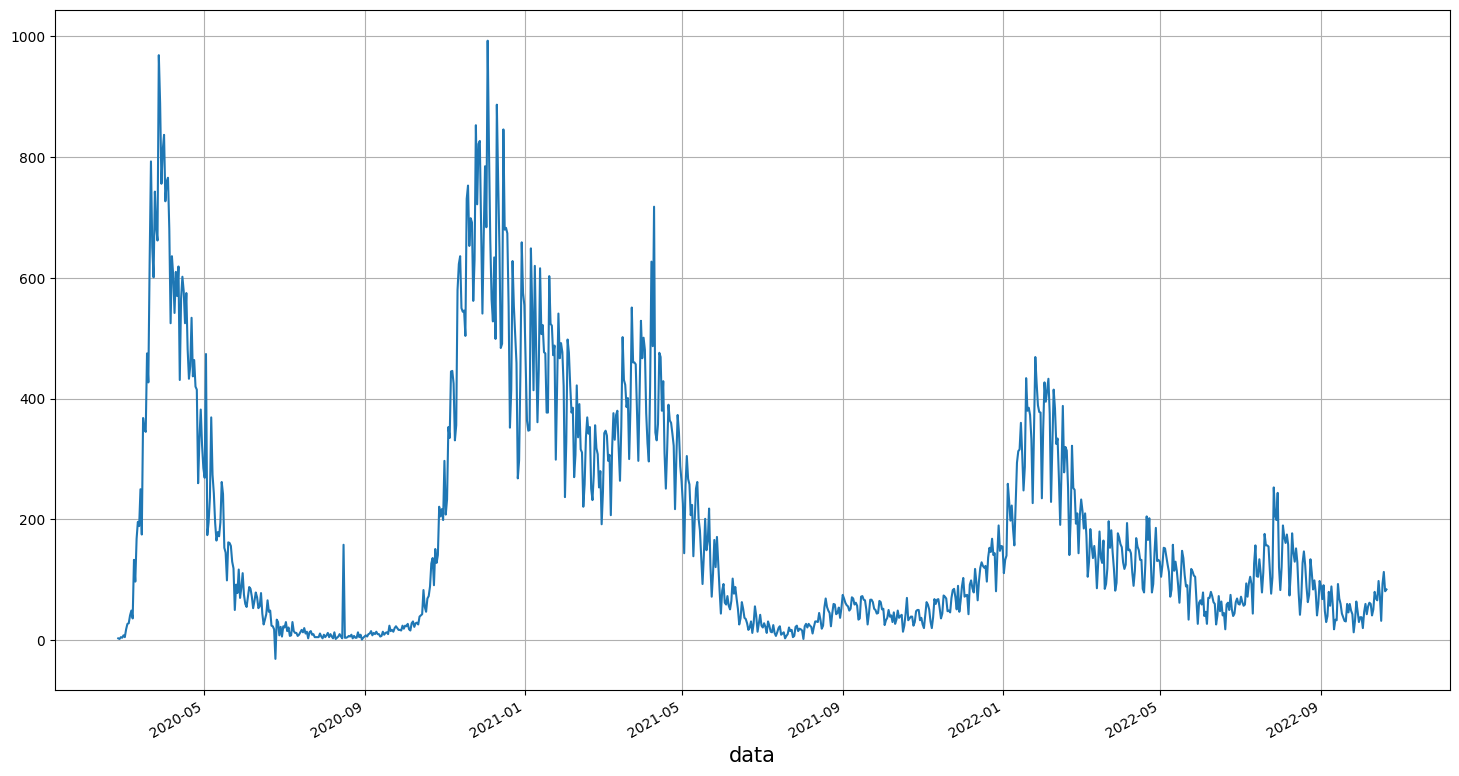

In [40]:
partial.deaths.plot()

Maybe it's easier to understand the lag with a weekly resample

<AxesSubplot: xlabel='data', ylabel='deaths'>

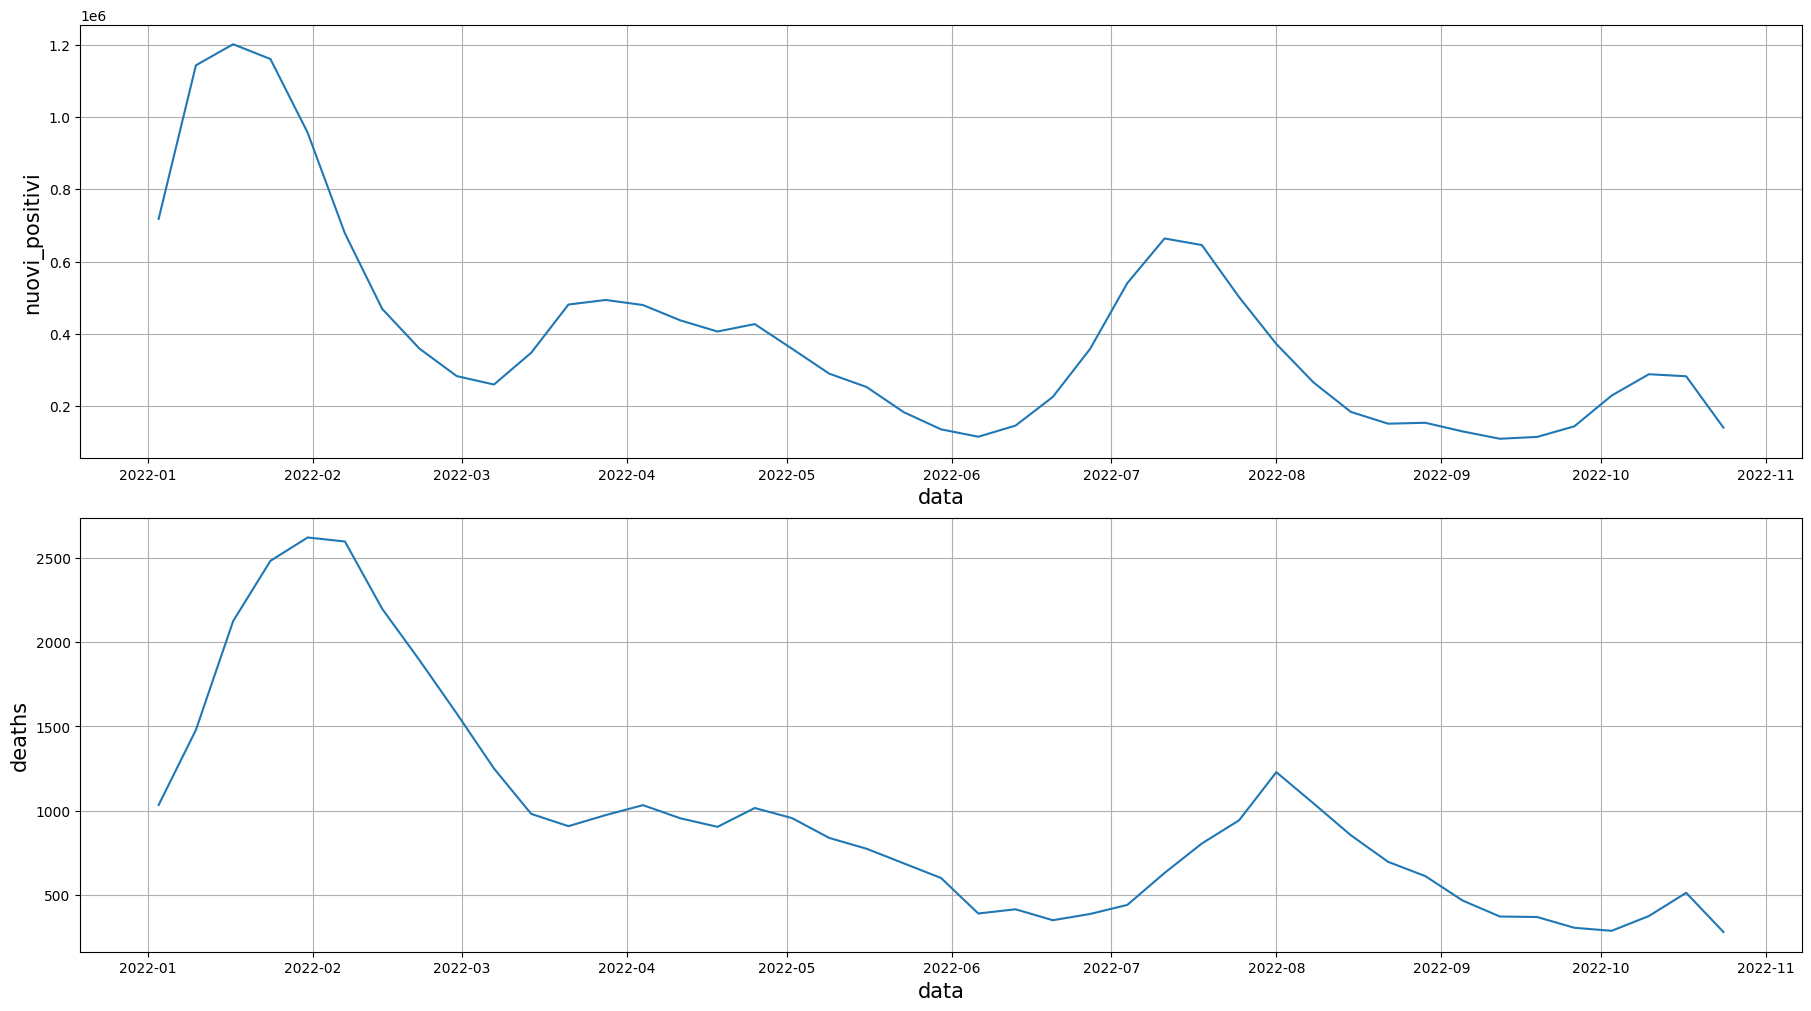

In [41]:
partial_res = partial.resample('W-MON').sum()
fig, axes = plt.subplots(2, 1, constrained_layout=True)
ax = axes.flatten()
sns.lineplot(partial_res.loc['2022','nuovi_positivi'], ax = ax[0])
sns.lineplot(partial_res.loc['2022','deaths'], ax = ax[1])

Taking the peaks of 2022 we can see that the delay is approximately 2 weeks.
<br>
Taking in account 2022 is a better index of maximum lag because of vaccines and cures developed in the previous 2 years.

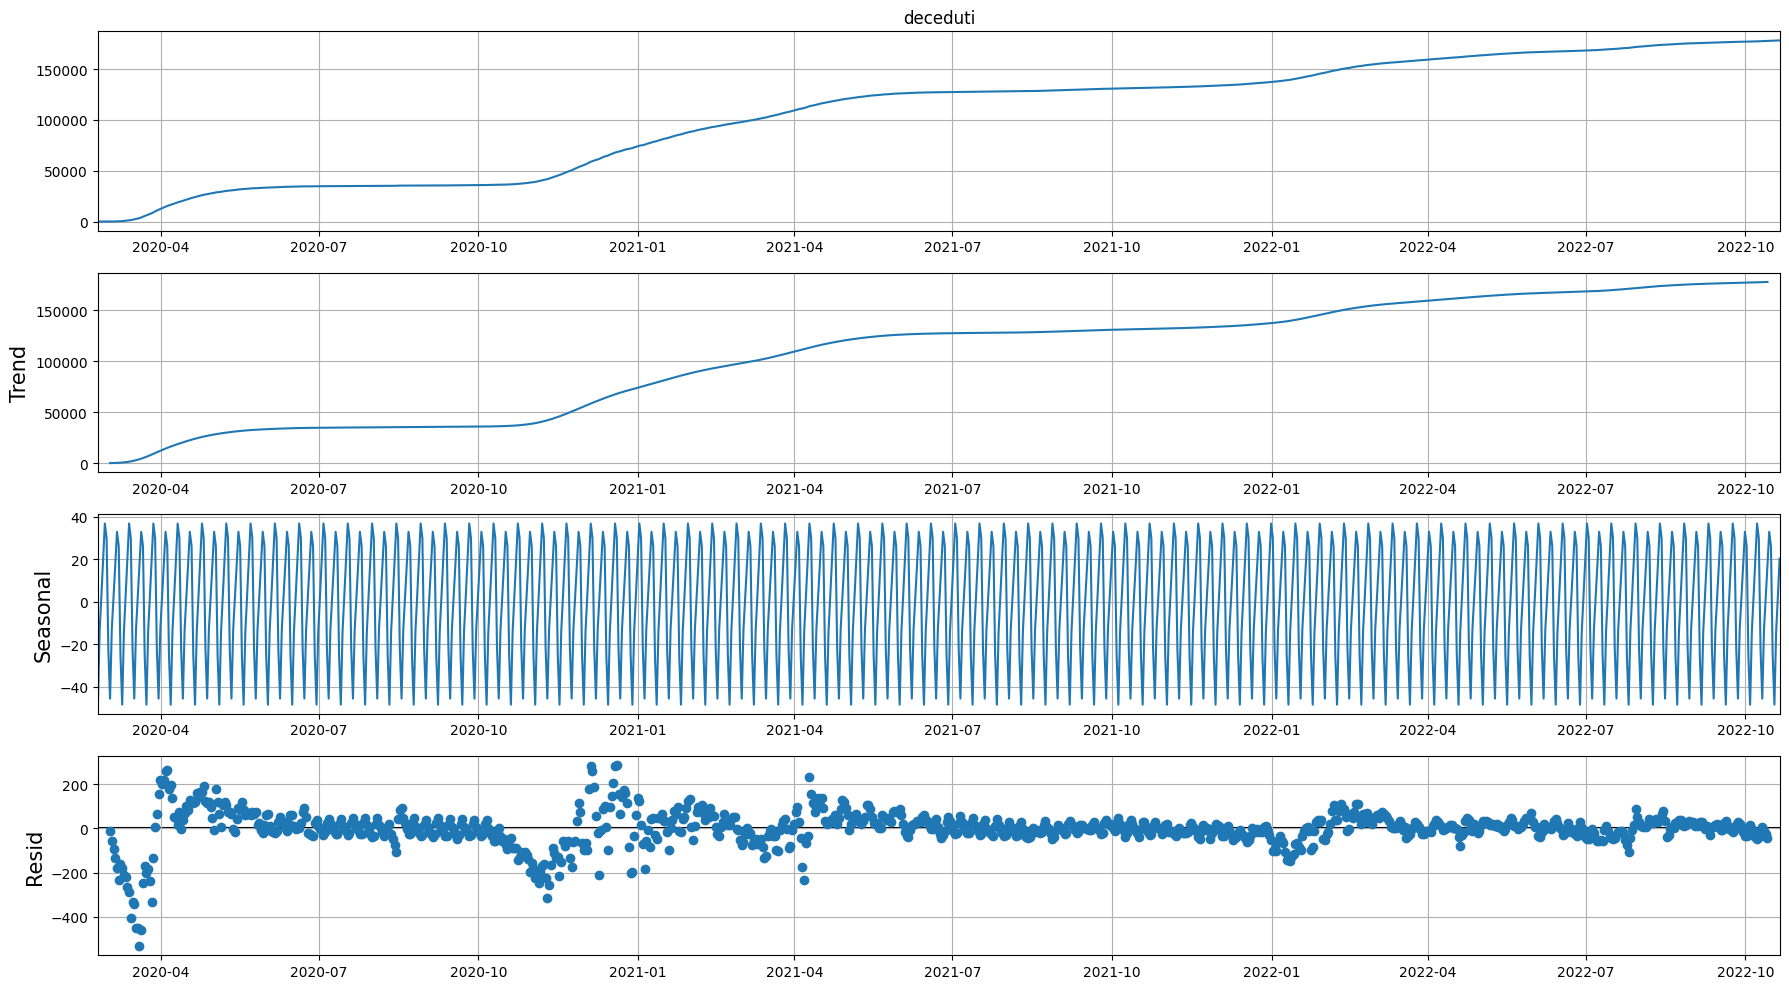

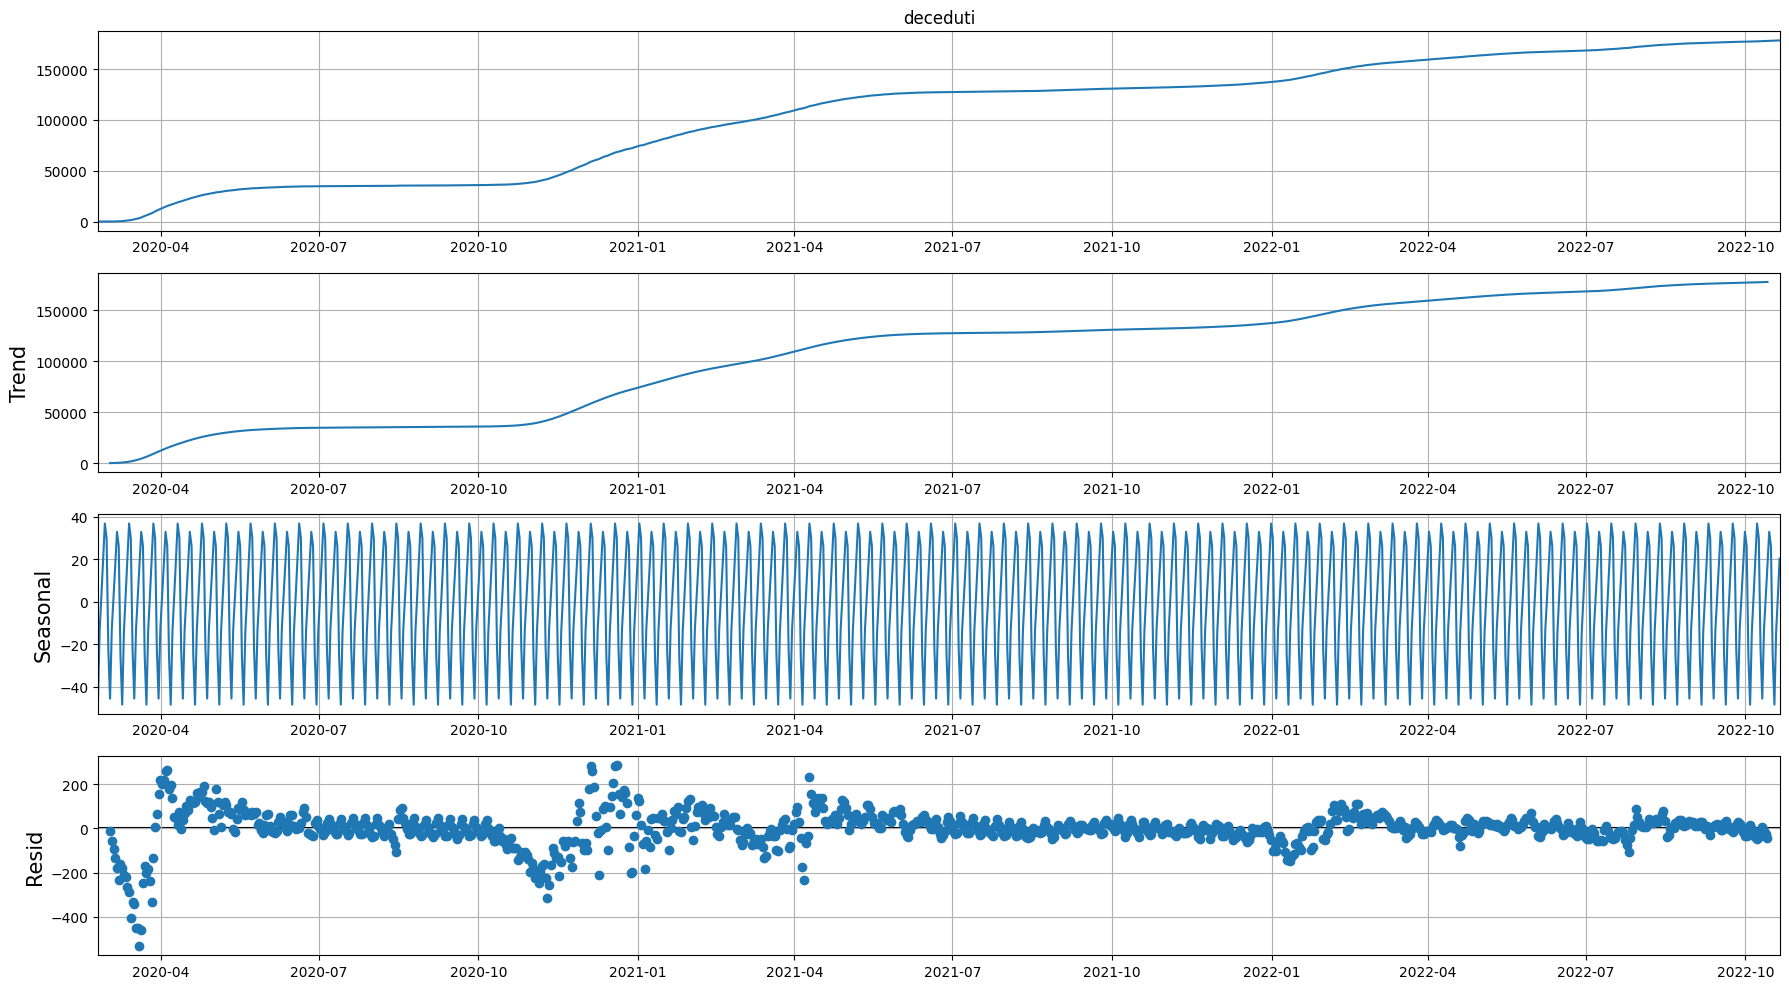

In [42]:
death_dec = seasonal_decompose(partial['deceduti'], period = 14)
death_dec.plot()

<AxesSubplot: xlabel='resid', ylabel='Count'>

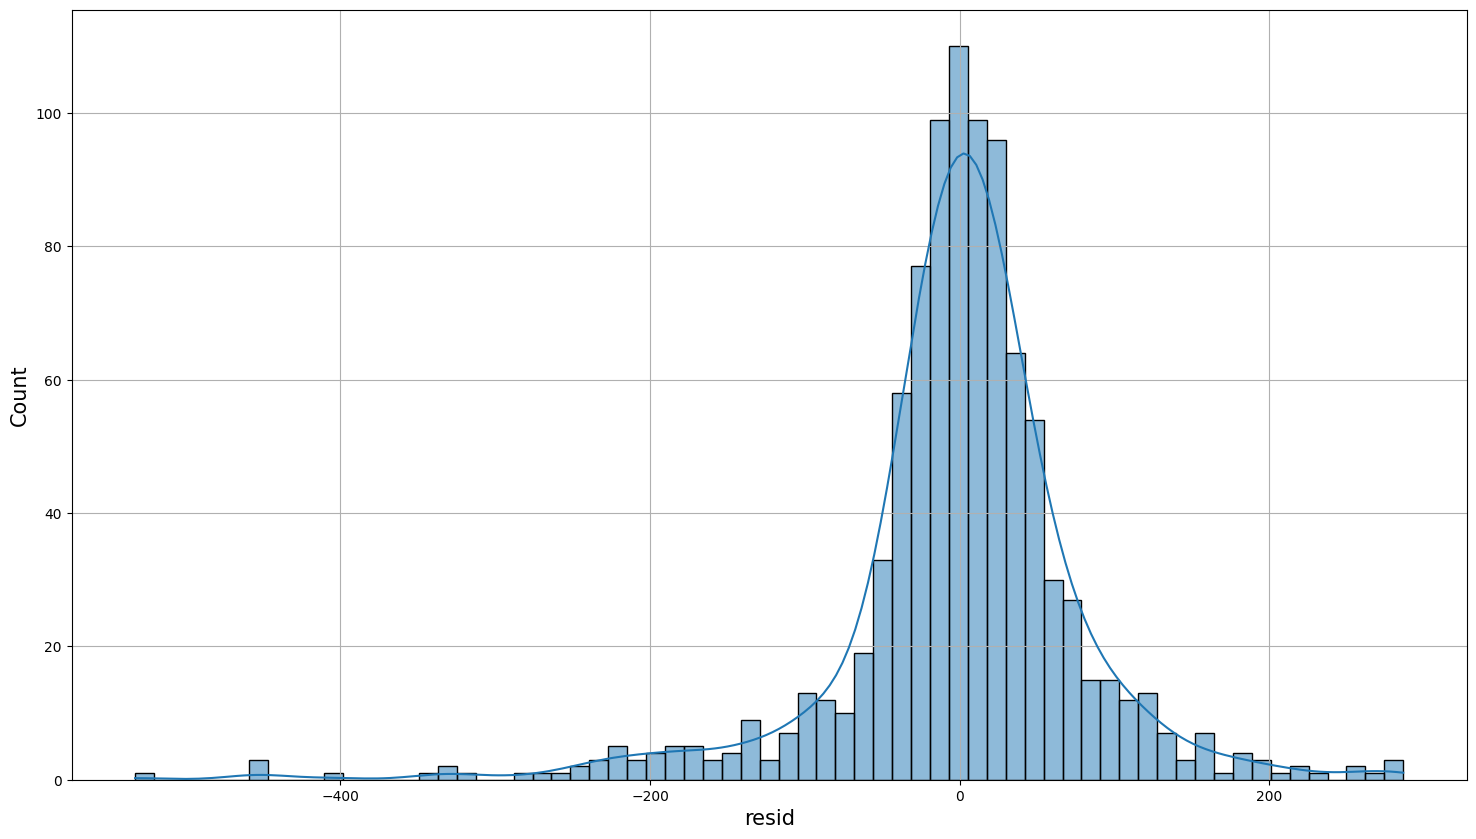

In [43]:
sns.histplot(death_dec.resid, kde = True)

In [44]:
counts, bins = np.histogram(death_dec.resid.dropna())
chi = scipy.stats.chisquare(counts)
expected = death_dec.resid.dropna().shape[0] -2
test = np.abs(expected - chi[0])/np.sqrt(2*expected)

display(Latex(f'expected $\chi^2$ value = {expected}, obtained $\chi^2$ value = {chi[0]}, p-value = {chi[1]}'))
print(f'Test = {test}')

<IPython.core.display.Latex object>

Test = 49.76734156371069


Clearly the series is not stationary 

In [45]:
window_size = 21
train = partial[['nuovi_positivi']]

X, Y = [], []

for i in range(window_size, train.shape[0]):
    X.append(train.values[i-window_size:i, 0])
    Y.append(train.values[i, 0])
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle = False)
    
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32') 
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')
    
mean = X_train[-1].mean()
std= X_train[-1].std()

X_train_scaled = (X_train - mean)/std
X_test_scaled = (X_test - mean)/std
Y_train_scaled = (Y_train - mean)/std
Y_test_scaled = (Y_test - mean)/std

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0],1,window_size,1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0],1,window_size,1)

In [46]:
covid_model = cnn_lstm(21)
covid_model.fit(X_train_scaled, Y_train_scaled, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
27/27 [==============================] - 2s 4ms/step - loss: 0.6601 - mse: 1.0401 - mae: 0.6601
Epoch 2/25
27/27 [==============================] - 0s 3ms/step - loss: 0.3432 - mse: 0.4858 - mae: 0.3432
Epoch 3/25
27/27 [==============================] - 0s 3ms/step - loss: 0.3017 - mse: 0.4167 - mae: 0.3017
Epoch 4/25
27/27 [==============================] - 0s 3ms/step - loss: 0.2750 - mse: 0.3599 - mae: 0.2750
Epoch 5/25
27/27 [==============================] - 0s 4ms/step - loss: 0.2591 - mse: 0.3198 - mae: 0.2591
Epoch 6/25
27/27 [==============================] - 0s 4ms/step - loss: 0.2396 - mse: 0.2852 - mae: 0.2396
Epoch 7/25
27/27 [==============================] - 0s 5ms/step - loss: 0.2242 - mse: 0.2554 - mae: 0.2242
Epoch 8/25
27/27 [==============================] - 0s 4ms/step - loss: 0.2090 - mse: 0.2323 - mae: 0.2090
Epoch 9/25
27/27 [==============================] - 0s 5ms/step - loss: 0.1972 - mse: 0.2105 - mae: 0.1972
Epoch 10/25
27/27 [==================

3/3 [==============================] - 1s 4ms/step


(4874.5073, 0.16171315)

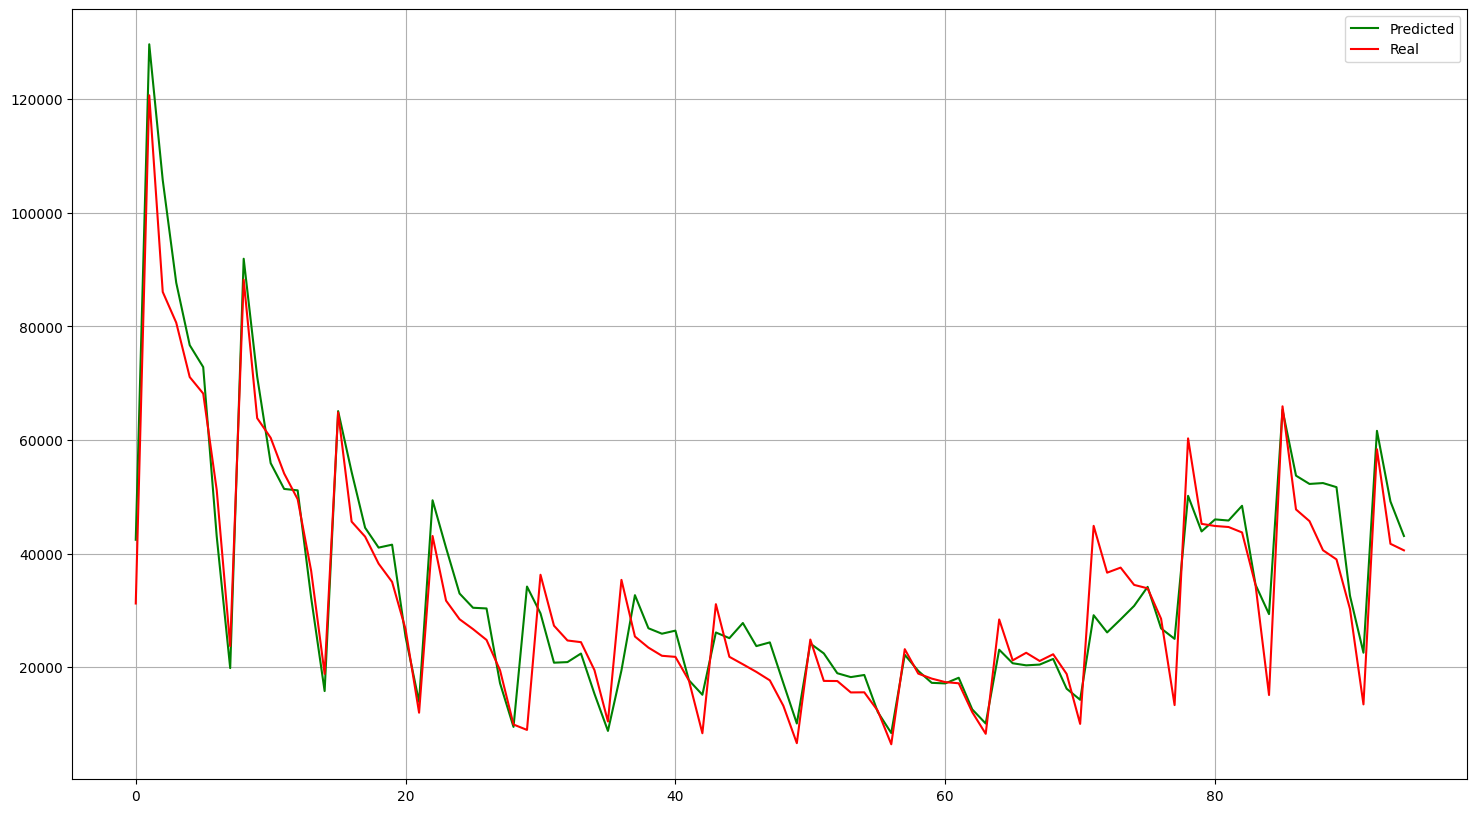

In [47]:
predicted  = covid_model.predict(X_test_scaled).flatten()
true = Y_test_scaled.flatten()

predicted = np.array(predicted) * std + mean
true = true * std + mean

plt.plot(predicted, color = 'green', label = 'Predicted')
plt.plot(true, color = 'red', label = 'Real')
plt.legend()
mean_absolute_error(predicted,true),mean_absolute_percentage_error(predicted, true)

The most suitable error is mean absolute percentage error because the scale varies a lot during time, so we need a normalization on the value